Códigos do arquivo implementados por Dorival Silva

  Para a avaliação dos métodos não supervisionado, a dupla desenvolverá os algoritmos K-means e DBSCAN. Neste arquivo, será tratado do algoritmo k-means, cujo funcionamento será descrito posteriormente. Inicialmente, irá se aplicar o algoritmo para separação de dados do conjunto de amostras recebidas pela porfessora responsável da disciplina. 
  
  Posteriomente, este arquivo buscará clusterizar dados de times de basquete que jogaram temporadas universitárias. O objetivo é que times com características semelhantes fiquem nos mesmos clusteres.  

**IMPORTS**

In [1]:
import numpy as np # 1 
import pandas as pd # 2 
import matplotlib.pyplot as plt
import math 
import random
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA



**Leitura do cluster.dat**

In [61]:
#leitura do cluster.dat
cabecalho = ['coluna 1', 'coluna 2']
datasetClusterDat = pd.read_csv("cluster.dat", decimal=".", sep=' ', names=cabecalho)

**Leitura dos dados escolhidos pelo grupo**

In [62]:
datasetCbb = pd.read_csv("cbb.csv", decimal=".", sep=',')
datasetCbb

TEAM  CONF   G   W  ...   WAB  POSTSEASON  SEED  YEAR
0         North Carolina   ACC  40  33  ...   8.6         2ND   1.0  2016
1              Wisconsin   B10  40  36  ...  11.3         2ND   1.0  2015
2               Michigan   B10  40  33  ...   6.9         2ND   3.0  2018
3             Texas Tech   B12  38  31  ...   7.0         2ND   3.0  2019
4                Gonzaga   WCC  39  37  ...   7.7         2ND   1.0  2017
...                  ...   ...  ..  ..  ...   ...         ...   ...   ...
2450        Michigan St.   B10  35  26  ...   6.7         S16   3.0  2013
2451             Arizona   P12  35  27  ...   4.6         S16   6.0  2013
2452              Oregon   P12  37  28  ...   2.9         S16  12.0  2013
2453            La Salle   A10  34  24  ...   0.3         S16  13.0  2013
2454  Florida Gulf Coast  ASun  35  24  ...  -4.0         S16  15.0  2013

[2455 rows x 24 columns]

**Removendo colunas que irão atrapalhar a analise dos dados, exemplo o  time**


In [8]:
datasetCbb = datasetCbb.drop(['TEAM', 'CONF', 'POSTSEASON', 'SEED'], axis=1)

**Classe Kmeans**

  Este método procura dividir os dados em "k" clusters, número previamente definido pelo usuário. Inicialmente,cria-se "k" referenciais, que serão os centros dos nossos clusters, chamados centróides. Essa escolha pode ser aleatória ou pode existir um pre-processamento que auxilie na escolha das coordenadas iniciais dos clusters. Em particular, neste relatório se compara a difereça dos resultados entre a escolha das coordenadas de maneira aleatória e entre a escolha utilizando a técnica k-means++. 
 Após a definição dos referenciais dos clusters, inicia-se a iteração do algoritmo. Primeiro, para cada observação (amostra), calcula-se a distância do mesmo ao centro dos clusters. Os clusters irão conter as observações cuja distância entre a observação e um cluster seja a menor. Feita essa divisão para todos as amostras, o centróide de cada cluster é redefinido para a média (ou mediana) das coordenadas das amostras pertencentes ao cluster. O processo iterativo do algoritmo termina quando o centro das coordenadas dos clusters não é alterado na iteração seguinte; isto é, quando a cardinalidade de cada cluster se mantém.

In [63]:
class KmeansTeste:
  def __init__(self, k):
    self.k = k

  def __distancia (self,v1,v2):
    return np.linalg.norm(v1-v2)
  #Soma dos quadrados das distancias ate o centro mais proximo
  def inertia(self):
    soma = 0
    for i in range(len(self.C)):
      d = self.__distancia(self.centroides[int(self.C[i])], self.data.iloc[i,:])
      soma += pow(d,2)
    return soma

  # Dados os centroides, para cada ponto, vejo para qual centroide ele pertence
  def __calcCluster(self,data, centroides,k):
    ret = np.zeros(len(data))
    A = 0
    for i in range(len(data)):
      dMin = self.__distancia(data.iloc[i,:], centroides[0])
      ret[i] = 0
      for j in range(1, k):
        d = self.__distancia(data.iloc[i,:], centroides[j])
        if d < dMin:
          dMin = d
          ret[i] = j
    return ret

  # Calcula os novos centroides, a partir da media dos pontos de cada cluster
  def __atualizarCentroides(self,cluster,data,centroides):
    media = np.zeros((self.k,2, data.shape[1]))
    for i in range(len(cluster)):
      for j in range(data.shape[1]):
        media[int(cluster[i])][0][j] += data.iloc[i,j]
        media[int(cluster[i])][1][j] += 1
    for i in range(self.k):
      for j in range(data.shape[1]):
        centroides[i][j] = media[i][0][j] / media[i][1][j]
    return centroides 

  # Metodo para iniciar os centroide podendo ser de modo aleatorio ou com k-means++
  def __getIniCentroides(self, mode='k-means++'):
    l,c = self.data.shape
    # Depois de escolher o primeiro de centroide de modo aleatorio
    # calculo a probabilidade dos outros pontos serem centroides, no qual quanto mais distante
    # maior a probabilidade, e apos calcular a probabilidade, utilizo a função
    # np.random.choice, para escolher um baseado na probabilidade dele.
    # E com isso descubro o segundo centroide, com o segundo centroide calculo a probabilidade com ele
    # e pego a menor probabilidade para cada ponto entre o calculo com ele e feito com o primeiro centroide e assim sucessivamente
    if mode.lower().strip() == 'k-means++':

      #Primeiro centroide
      np.random.seed(0)
      self.centroides = np.zeros((self.k, c))
      self.centroides[0] = self.data.iloc[np.random.choice(l),:]
      distancia_para_centroide = np.zeros(l)
      for i in range(l):
        distancia_para_centroide[i] = self.__distancia(self.centroides[0], self.data.iloc[i,:])
      for i in range(1,self.k):
        prob = distancia_para_centroide ** 2
        index = np.random.choice(l,size=1, p=prob/np.sum(prob))
        self.centroides[i] = self.data.iloc[index,:]
        distancia_nova = np.zeros(l)
        for j in range(l):
          distancia_nova[j] = self.__distancia(self.centroides[i], self.data.iloc[j,:])
          distancia_para_centroide[j] = np.min((distancia_para_centroide[j], distancia_nova[j]))
    # Pega 3 pontos aleatorios no data
    elif mode.lower().strip() == 'random':
      self.centroides = np.zeros((self.k,c))
      for i in range(self.k):
        for j in range(c):
          centroideRand = random.randint(0,l)
          self.centroides[i][j] = self.data.iloc[centroideRand,j]
    # Caso nao seja nem random nem k-means++
    else:
      raise NameError('Tipo de inicialização de centroide invalido!')

 # Metodo para treinar o modelo, no qual pega os centroides iniciais e 
 # a partir dele vai recalculando ate o centroide convergir, ou seja,
 # o novo centroide é igual ao centroide anterior
  def fit(self, data, init_centroides = 'k-means++'):
    self.data = data.copy()
    self.__getIniCentroides(init_centroides)
    self.C = self.__calcCluster(self.data,self.centroides,self.k)
    continua = True
    while(continua):
      centroidesN = self.__atualizarCentroides(self.C,self.data, self.centroides)
      continua = False
      for i in range(self.k):
        for j in range(self.data.shape[1]):
          if self.centroides[i][j] != centroidesN[i][j]:
            continua = True
      self.centroides = centroidesN
      self.C = self.__calcCluster(self.data,self.centroides,self.k)  
  # Dado um conjuto de dados, verifica no modelo treinado a que 
  # cluster pertence cada ponto dos dados
  def predict(self,data):
    return self.__calcCluster(data.copy(), self.centroides,self.k)
  #Chama a função .fit e a função .predict
  def fit_predict(self,data, init_centroides = 'k-means++'):
    self.fit(data, init_centroides)
    return self.predict(self.data)

In [64]:
# Para splitar os dados, os dados sao embaralhados e selecionados os
# p*len primeiros e os (1-p)*len ultimos dados
def splitData(data, p=0.9):
  embaralhado = data.iloc[np.random.permutation(len(data))]
  d1 = embaralhado.iloc[0:int(embaralhado.shape[0]*p),:]
  d2 = embaralhado.iloc[int(embaralhado.shape[0]*p):,:]
  return d1,d2

In [65]:
# Aplica a normalização em cada coluna dos dados
def normalizar(data, norms):
    for i in range(data.shape[1]):
      norm = np.linalg.norm(data.iloc[:,i])
      data.iloc[:,i] /= norm
      norms.append(norm)

    return data

In [66]:
# PLota o grafico
def plotarGrafico(clusters,x, y,titulo, labelX='x', labelY='y',  save=True, centroides=None):
  dicionarioCores = {0 : 'red', 1 : 'blue', 2: 'green', 3: 'pink', 4: 'yellow'}
  label_color = [dicionarioCores[l] for l in clusters]
  plt.figure(figsize = (12,12))
  plt.scatter(x,y, c=label_color, alpha=0.3) 
  plt.xlabel(labelX, fontsize=18)
  plt.ylabel(labelY, fontsize=18)
  plt.title(titulo)
  if centroides != None:
    plt.scatter(centroides[0],centroides[1], marker='X',s=200, c='red')
  if save:
    plt.savefig(titulo + '.jpg')
  plt.show()

In [67]:
# Metodo para auxiliar no calculo de distancia
def distancia(v1,v2):
  return np.linalg.norm(v1-v2)

In [68]:
# Metodo que calcula o elbow e plotar o grafico
# para um intervalo de k, como default temos k=[1..10]
def elbow(data,K=range(1,10)):
  somaDosQuadrados = []
  for k in K:
    km = KmeansTeste(k)
    km.fit(data)
    somaDosQuadrados.append(km.inertia())
  plt.plot(K, somaDosQuadrados, 'x-')
  plt.xlabel('k')
  plt.ylabel('Soma dos quadrados')
  plt.title('Elbow')
  plt.show()

In [69]:
# Metodo que percorre a lista de cluster e verifica qual o cluster mais proximo um do outro
# e retorna uma matrix NxN, no qual cada linha tera um elemento marcado com 1 que representa
# o cluster mais proximo
def getClustersMaisProximos(centroides):
  mat = np.asarray([[0]*len(centroides)] * len(centroides))
  for i in range(len(centroides)):
    dist = 0
    c = 0
    for j in range(len(centroides)):
      d = distancia(centroides[j], centroides[i])
      if (dist == 0 or d < dist) and d != 0:
        dist = d
        c = j
    mat[i][c] = 1
  return np.asarray(mat)

# Pega todos os index dentro do cluster de um cluster especifico
def get_index_cluster(clusters, cluster):
  return np.where(clusters == cluster)[0]
# Retorna uma lista com todos os k linhas, com cada linha é
# um conjuto de index pertencente a umk cluster
def get_indexes_cluster(clusters, centroides):
  listIndexes = []
  for i in range(len(centroides)):
    listIndexes.append(get_index_cluster(clusters, i))
  return listIndexes

# Metodo que calcula o coeficinete de silhouette e retorna o coefiente medio,
# e uma lista com o coeficiente para cada ponto 
def silhouette (data, clusters, centroids):
    sil = 0
    
    listIndexs = get_indexes_cluster(clusters, centroids)
    silhouttes = []
    data = np.asarray(data)
    cltMaisProximos = getClustersMaisProximos(centroids)
    
    for i in range(len(data)):
      x = data[listIndexs[int(clusters[i])]] - data[i]
      A = np.mean([np.linalg.norm(y) for y in x] )
      cltMaisProximo = cltMaisProximos[int(clusters[i])]
      cltMaisProximo = np.where(cltMaisProximo == 1)[0][0]
      x = data[listIndexs[int(cltMaisProximo)]] -  data[i]
      B = np.mean([np.linalg.norm(y) for y in x] )
      sil += (B-A)/max(A,B)
      silhouttes.append((B-A)/max(A,B))


    return sil/len(data), np.asarray(silhouttes);


In [70]:
# Calcula o coeficiente de silhouette para cada um intervalo
# de k ( por default k=[1..10]), e plota os grafico
def silhouette_method(data, K = range(1,11)):
  graf = []
  for k in K:
    km = KmeansTeste(k)
    X_cl = km.fit_predict(data)
    graf.append(silhouette(data, X_cl, km.centroides)[0])

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(data) + (k + 1) * 10])
    S = silhouette(data, X_cl, km.centroides)
    y_lower = 10
    for i in range(k):
        # Trecho pego na pagina da scikit-learn para podermos plotar o grafico
        #----------------------------------------------------------------------
        ith_cluster_silhouette_values = S[1][X_cl==i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / len(km.centroides))
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=S[0], color="red", linestyle="--")
    ax1.set_yticks([]) 
    ax1.set_xticks([-0.3, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()
    #--------------------------------------------------------------------------

  plt.plot(K, graf, 'x-')
  plt.xlabel('k')
  plt.ylabel('Coeficientes')
  plt.title('Silhouette Coeficient')
  plt.show()


**Normalizando os dados**

Normalizamos os dados, pois tivemos problemas com os resultados obtidos sem normalização, uma vez que uma das coordenadas era valores muito maiores que a outra; ou seja, acabava tendo uma maior importância no cálculo de distância. Abaixo, segue exemplo:

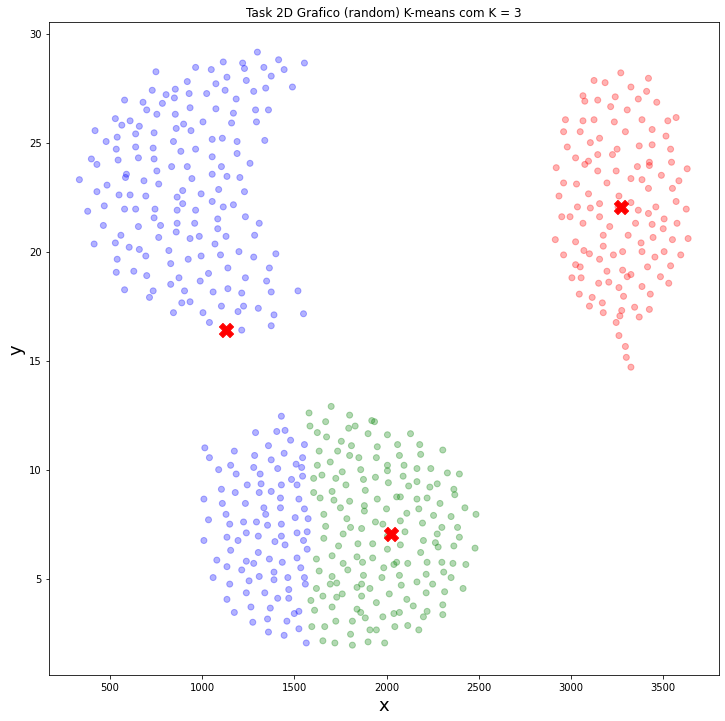

In [72]:
k=3
km = KmeansTeste(k)
km.fit(datasetClusterDat,init_centroides='k-means++')
X_cl = km.predict(datasetClusterDat)
c1 = 0
c2 = 1
plotarGrafico(X_cl, x=datasetClusterDat.iloc[:,c1], y=datasetClusterDat.iloc[:,c2],  titulo= "Task 2D Grafico (random) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]])

**Dividindo os dados entre treino e teste**

O treino e teste serão divididos na proporção 10 para 90.

In [73]:
normTreinoClusterDat, normTesteClusterDat = splitData(normDataSetClusterDat, 0.9)
normTreinoCbb, normTesteCbb = splitData(normDataSetCbb, 0.9)

In [45]:
normsTreinoClusterDat = []
normTreinoClusterDat = normalizar(treinoClusterDat.copy(),normsTreinoClusterDat)
normsTesteClusterDat = []
normTesteClusterDat = normalizar(testeClusterDat.copy(),normsTesteClusterDat)


In [46]:

normsTreinoCbb = []
normTreinoCbb = normalizar(treinoCbb.copy(),normsTreinoCbb)
normsTesteCbb = []
normTesteCbb = normalizar(testeCbb.copy(),normsTesteCbb)


**Treinando com o método random e plotando o gráfico com k entre 1 a 3**


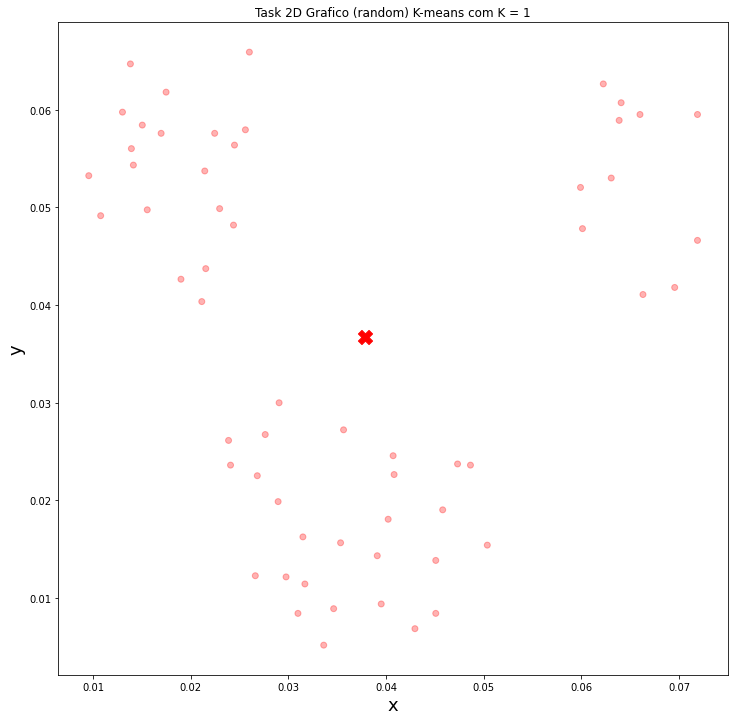

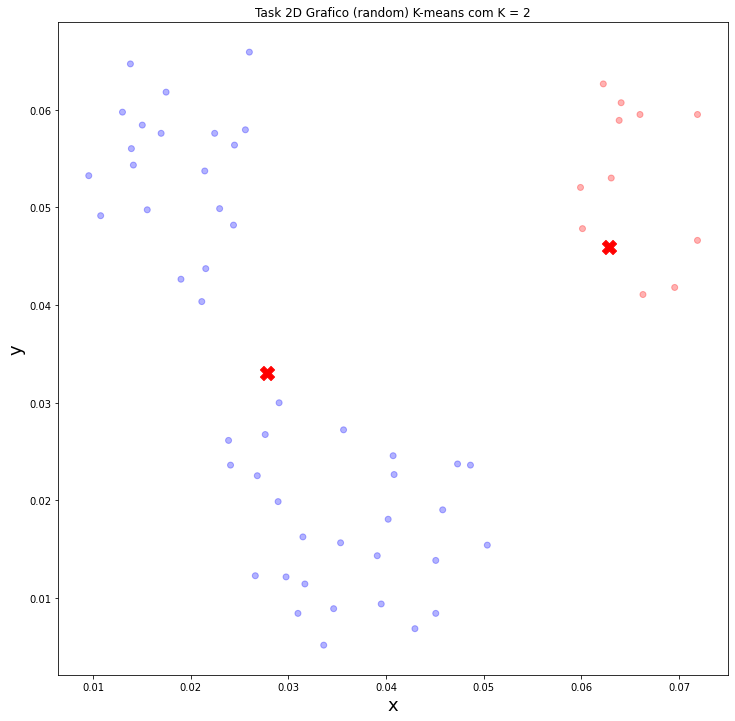

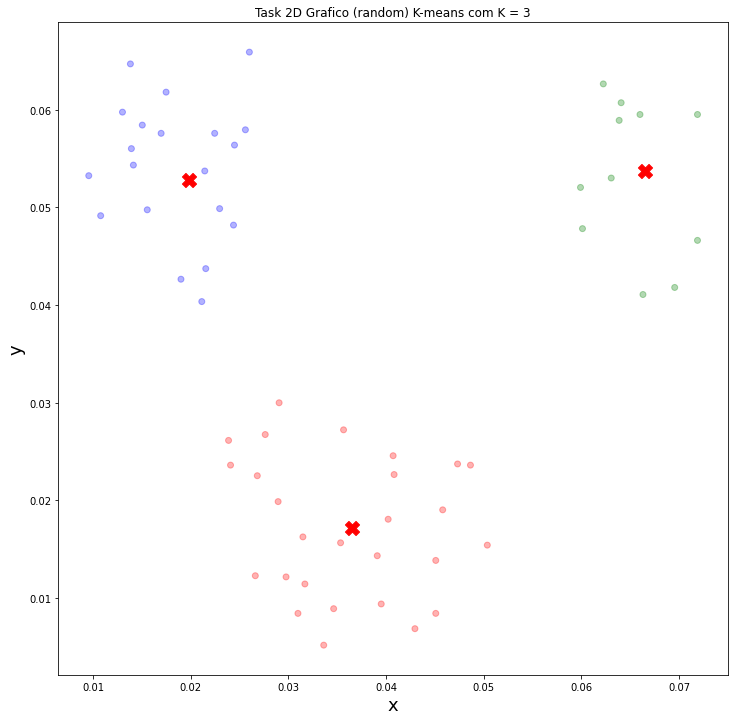

In [76]:
for k in range(1,4):
  km = KmeansTeste(k)
  km.fit(normTreinoClusterDat,init_centroides='random')
  X_cl = km.predict(normTesteClusterDat)
  c1 = 0
  c2 = 1
  plotarGrafico(X_cl, x=testeClusterDat.iloc[:,c1], y=testeClusterDat.iloc[:,c2],  titulo= "Task 2D Grafico (random) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]])

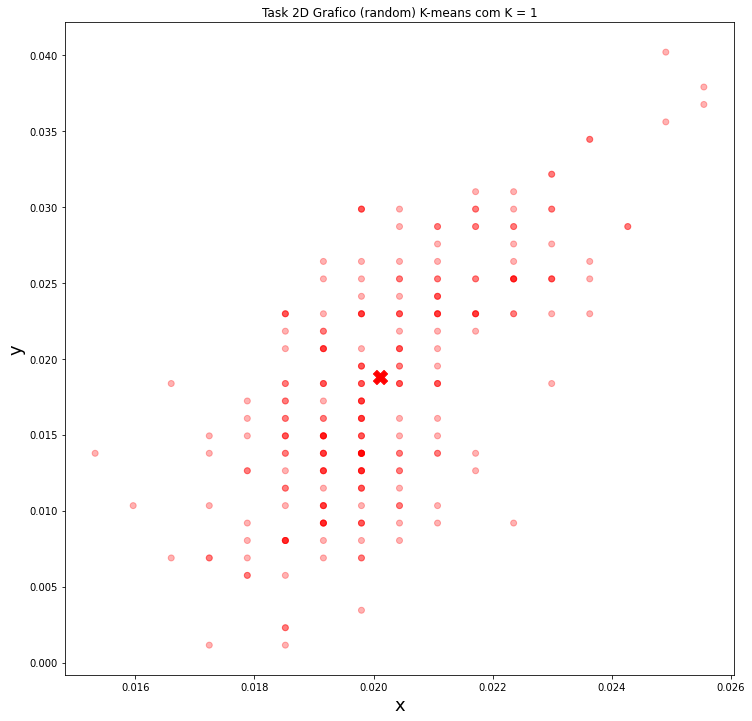

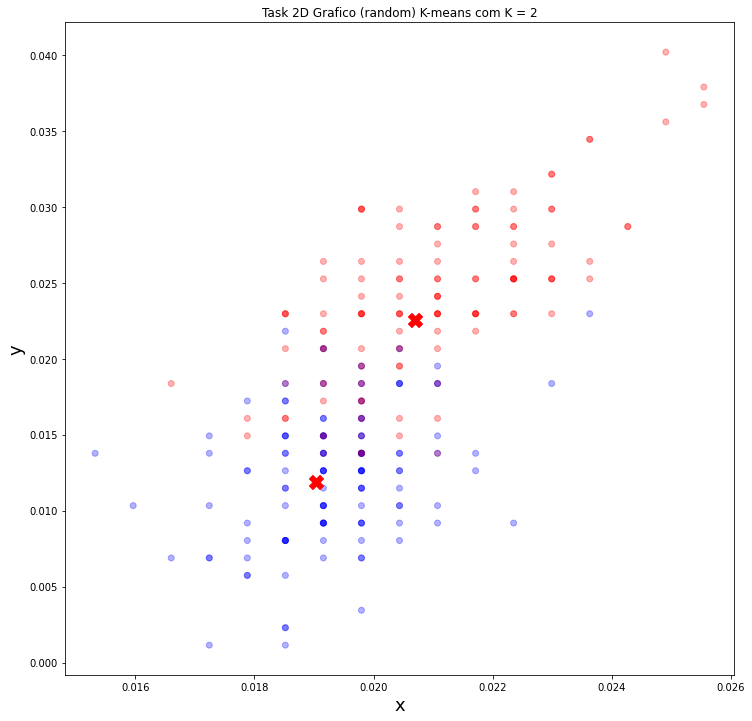

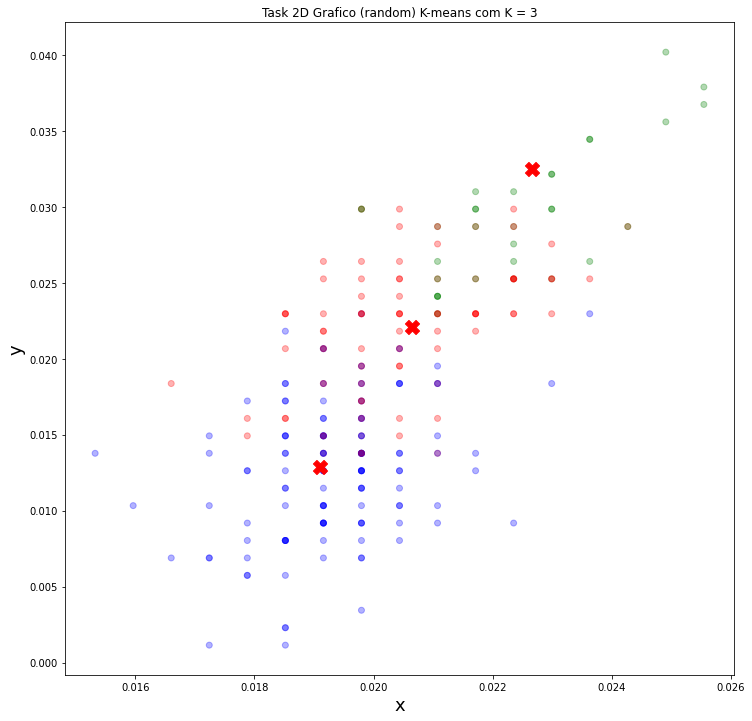

In [77]:
for k in range(1,4):
  km = KmeansTeste(k)
  km.fit(normTreinoCbb,init_centroides='random')
  X_cl = km.predict(normTesteCbb)
  c1 = 0
  c2 = 1
  plotarGrafico(X_cl, x=testeCbb.iloc[:,c1], y=testeCbb.iloc[:,c2],  titulo= "Task 2D Grafico (random) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]])

**Treinando com o metodo k-means++ e plotando o gráfico com k entre 1 e 3**


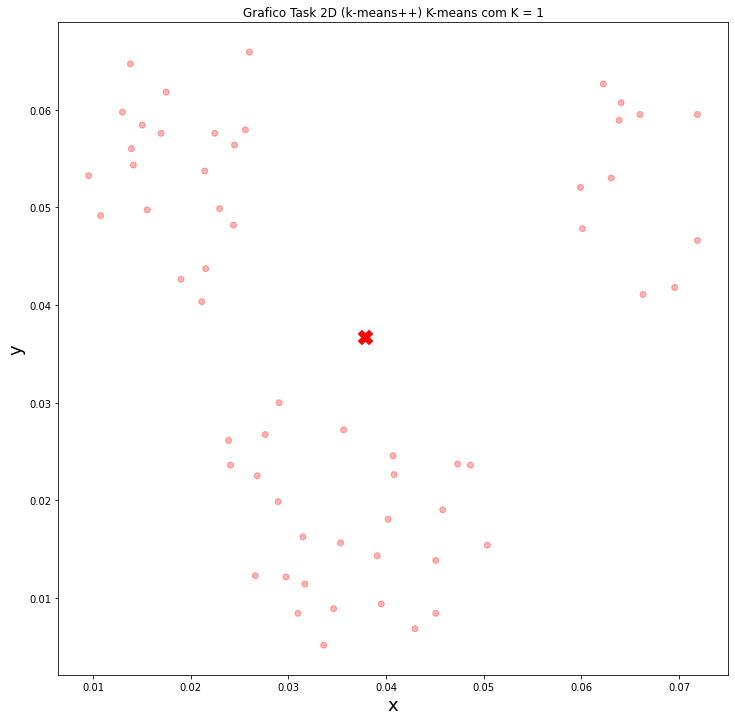

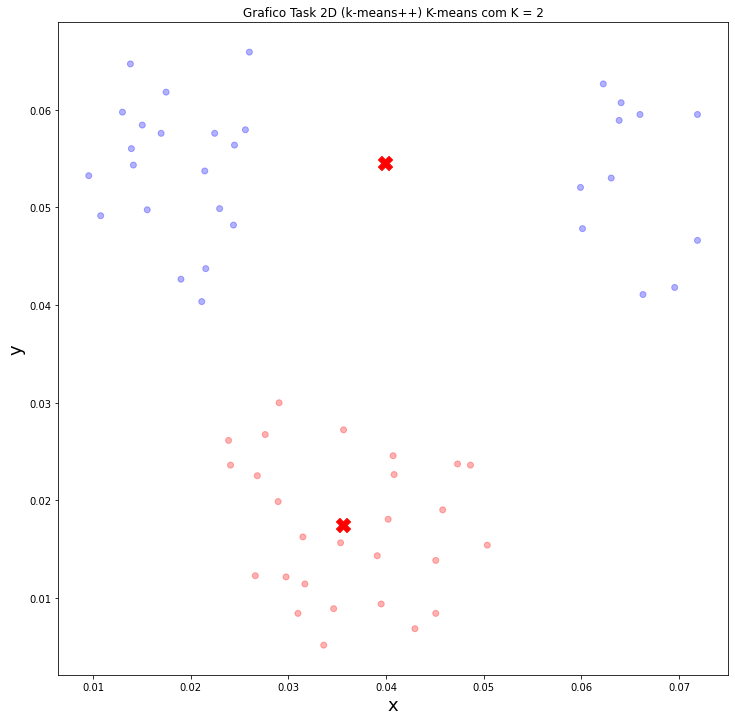

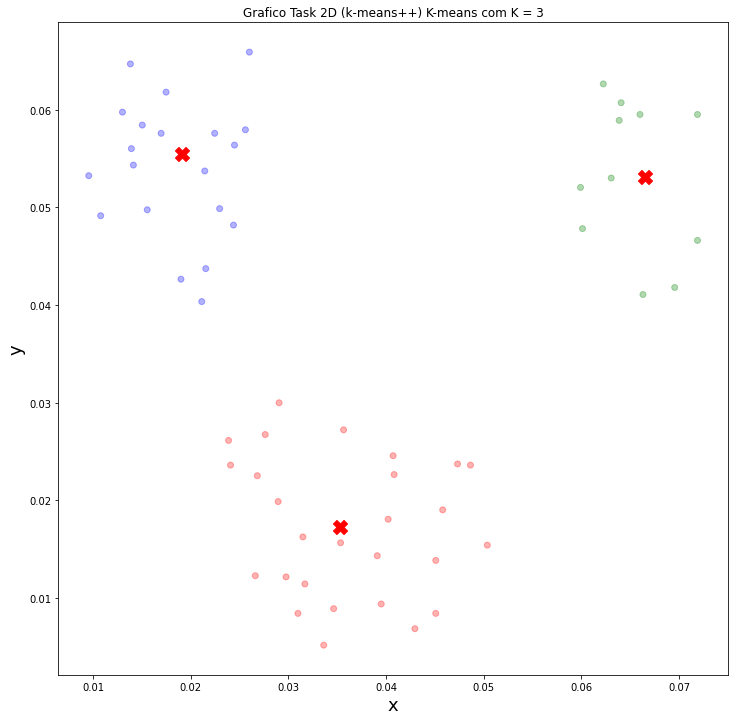

In [78]:
for k in range(1,4):
  km = KmeansTeste(k)
  km.fit(normTreinoClusterDat)
  X_cl = km.predict(normTesteClusterDat)
  c1 = 0
  c2 = 1
  plotarGrafico(X_cl, x=normTesteClusterDat.iloc[:,c1], y=normTesteClusterDat.iloc[:,c2],  titulo= "Grafico Task 2D (k-means++) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]])

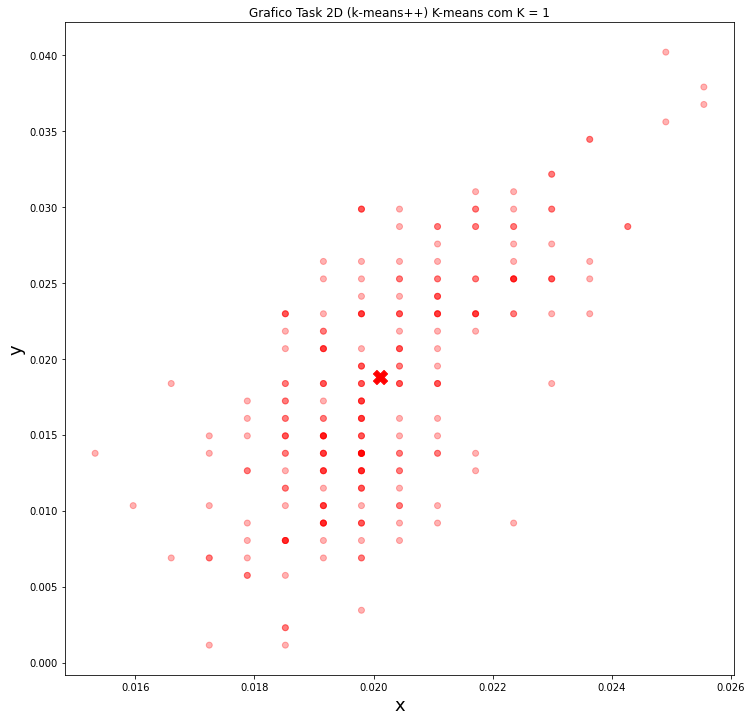

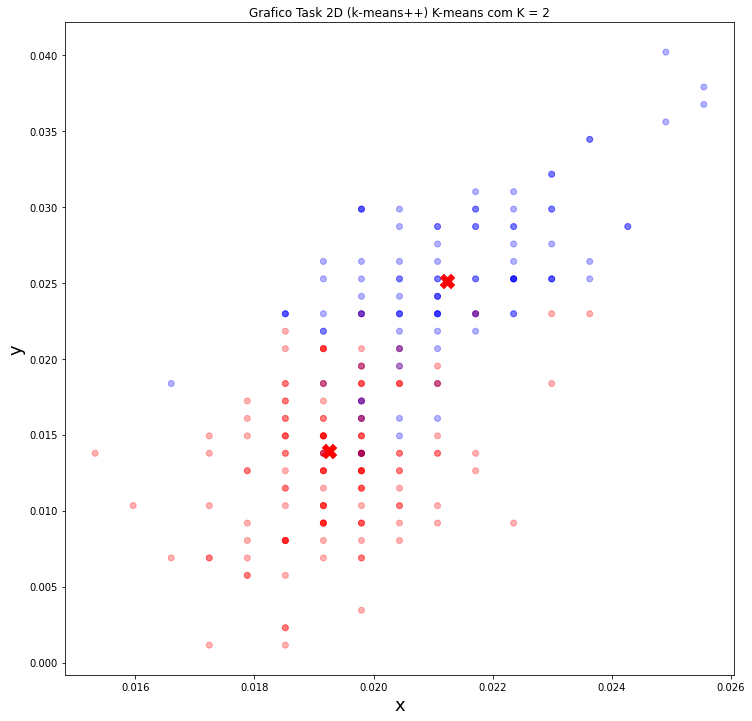

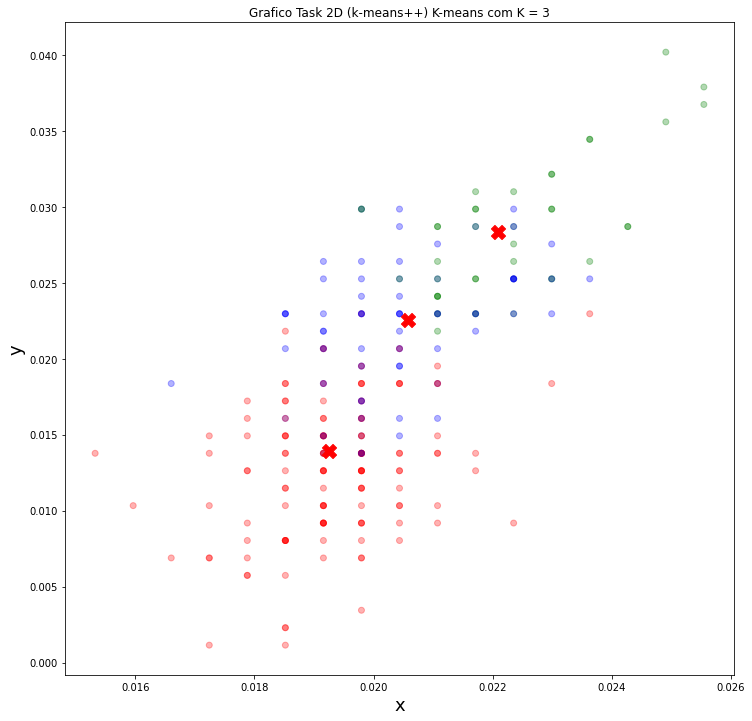

In [79]:
for k in range(1,4):
  km = KmeansTeste(k)
  km.fit(normTreinoCbb)
  X_cl = km.predict(normTesteCbb)
  c1 = 0
  c2 = 1
  plotarGrafico(X_cl, x=normTesteCbb.iloc[:,c1], y=normTesteCbb.iloc[:,c2],  titulo= "Grafico Task 2D (k-means++) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]])

Observou-se com os gráficos acima que, utilizando o pre-processamento do k-mean++ para estes dados, a clusterização teve melhor distribuição, em relação a distância entre clusters e densidade. 

A seguir, utillizaremos a técnica do cotovelo para avaliar qual é a melhor escolha de k para o conjunto de dados bidimensional e para o de nossa escolha. Faremos o mesmo utilizando a técnica da silhueta.

**Elbow para a Task 2D (arquivo cluster.dat)**

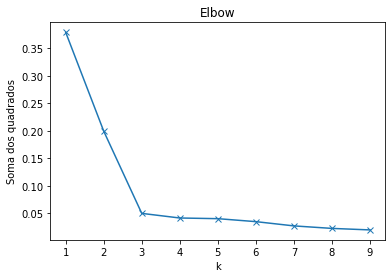

In [83]:
elbow(normTreinoClusterDat)

**Elbow para a Task escolhida (cbb.csv)**

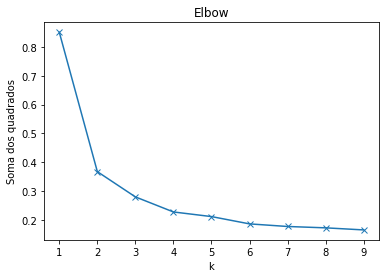

In [84]:
elbow(normTreinoCbb)

**Silhouette para Task 2D**

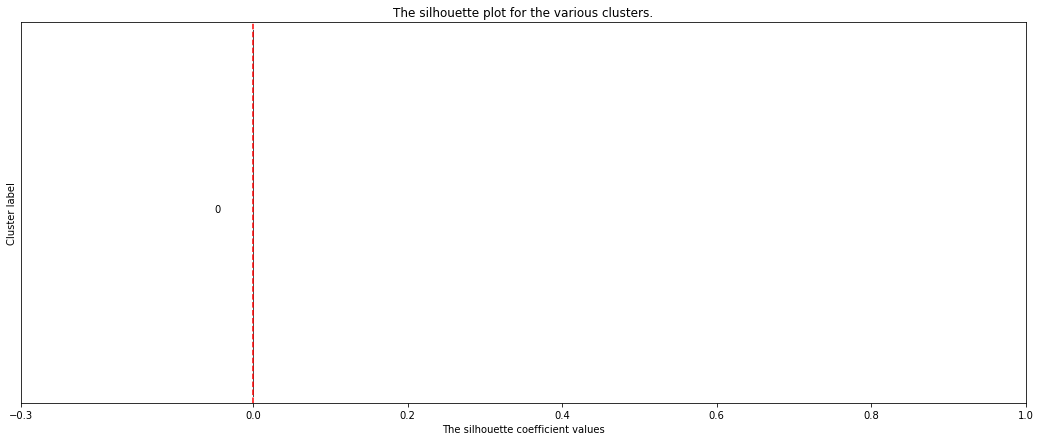

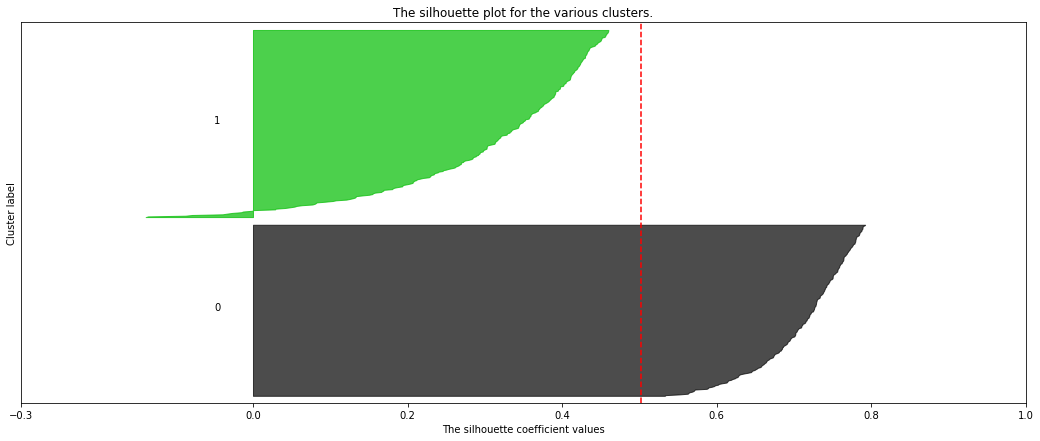

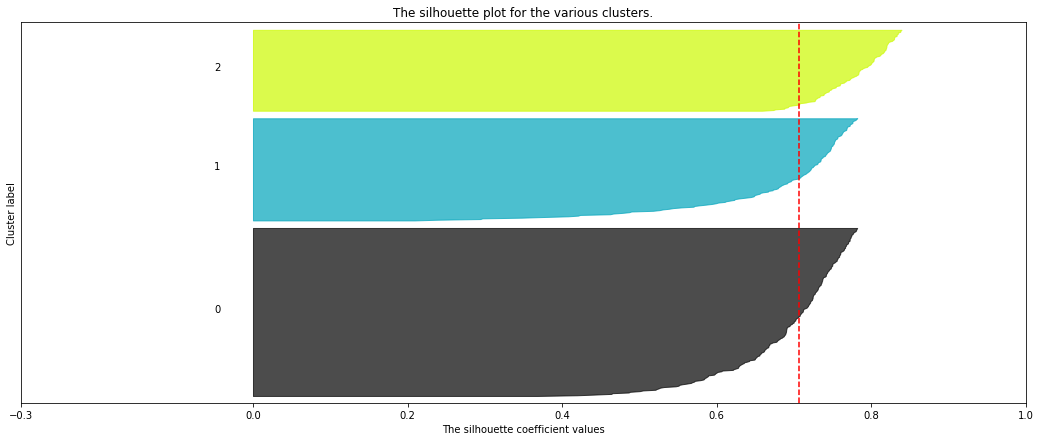

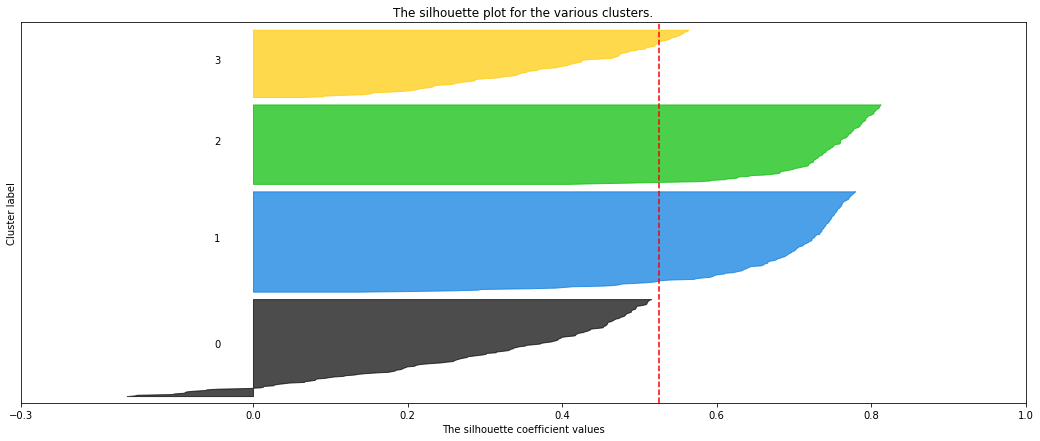

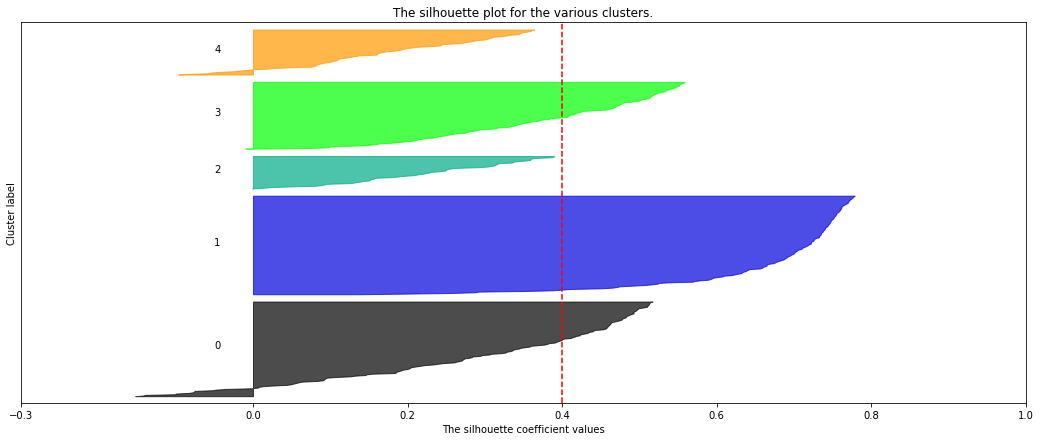

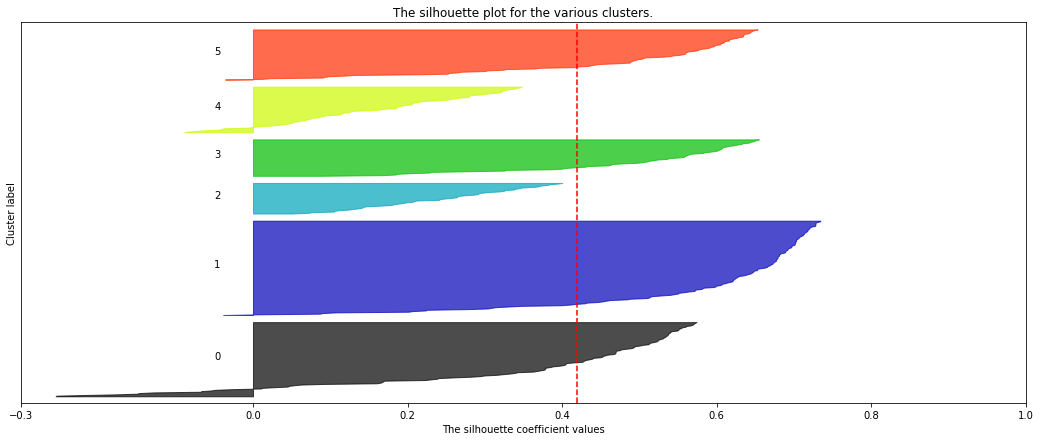

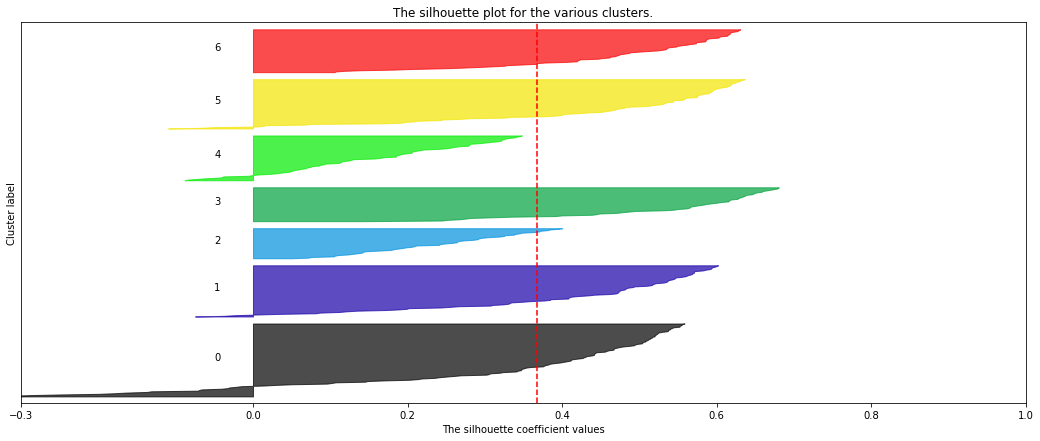

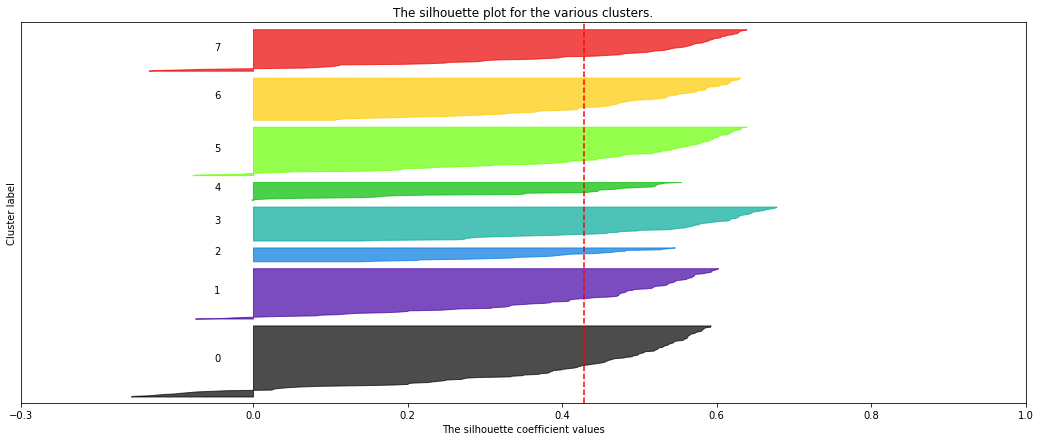

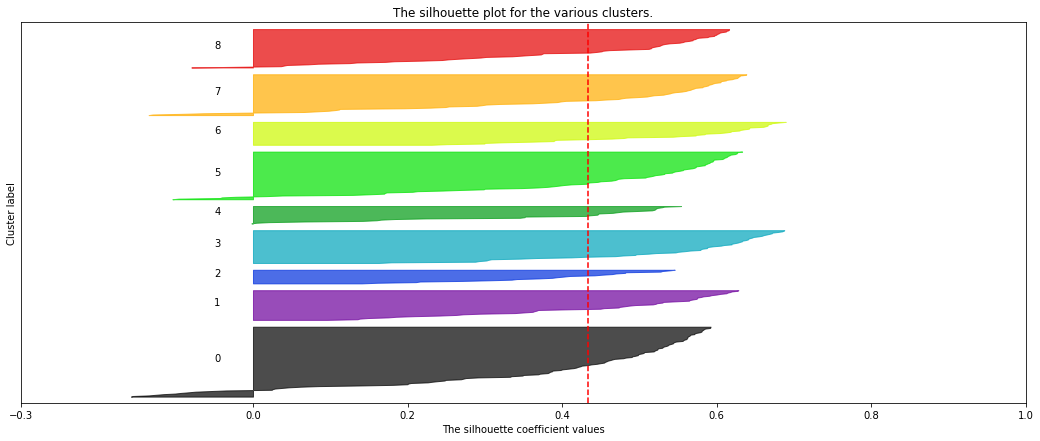

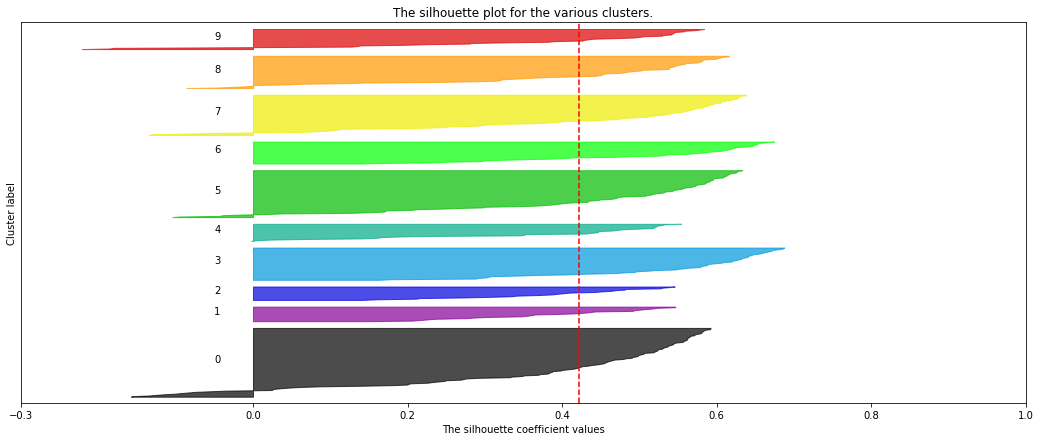

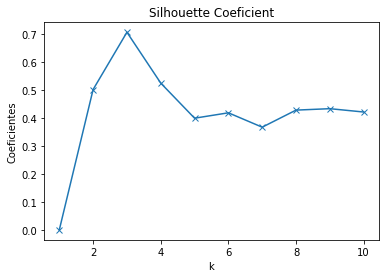

In [85]:
silhouette_method(normTreinoClusterDat)

Analisando os gráficos gerados, pode-se concluir que os melhores valores para o K, para a task 2D e para a task que escolhemos é igual a 3; visto que possui maior coeficiente de silhueta (para o conjunto de dados bidimensional), e por ser o ponto em que o elbow possui maior variação para tender a paralelismo com o eixo x, para ambos. 

A seguir, plotaremos alguns gráficos para mostrar o comportamento do método, em perspectiva de diferentes coordenadas. As cores representando seus respectivos clusters.

In [86]:
k=3
km = KmeansTeste(k)
km.fit(normTreinoCbb)
X_cl = km.predict(normTesteCbb)


coordenada x: Number of games played, coordenada y: Number of games won

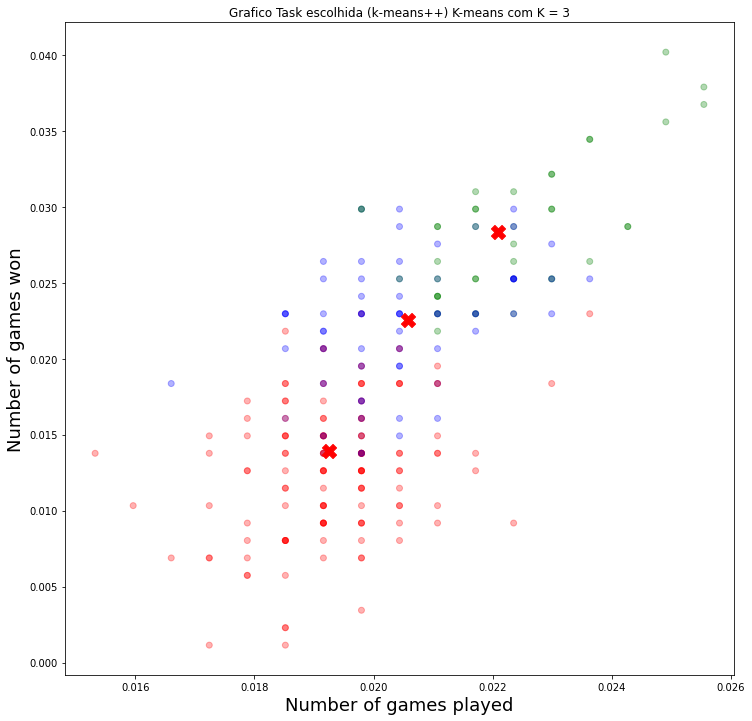

In [87]:
c1 = 0
c2 = 1
plotarGrafico(X_cl, x=normTesteCbb.iloc[:,c1], y=normTesteCbb.iloc[:,c2],  titulo= "Grafico Task escolhida (k-means++) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]], labelX='Number of games played', labelY='Number of games won')

Adjusted Offensive Efficiency X Adjusted Defensive Efficiency

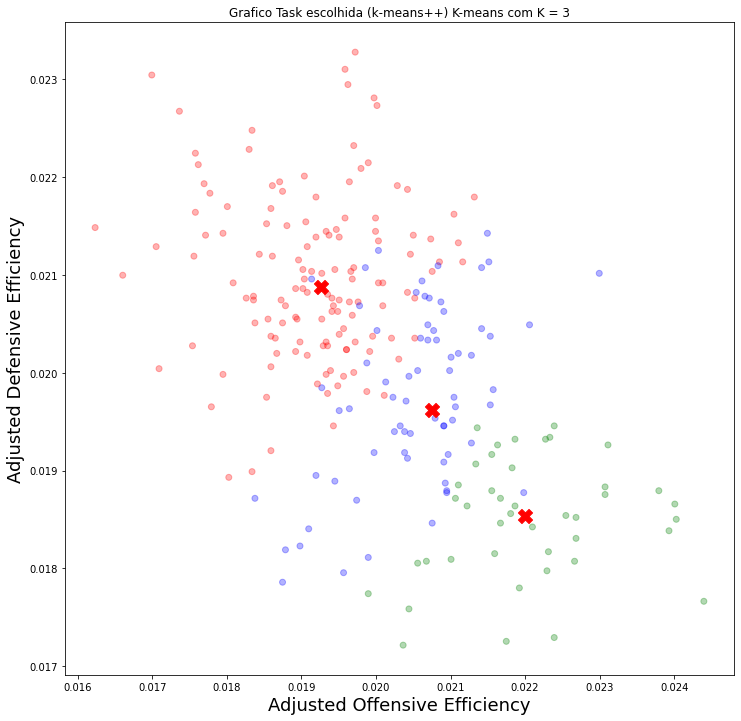

In [88]:
c1 = 2
c2 = 3
plotarGrafico(X_cl, x=normTesteCbb.iloc[:,c1], y=normTesteCbb.iloc[:,c2],  titulo= "Grafico Task escolhida (k-means++) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]], labelX='Adjusted Offensive Efficiency', labelY='Adjusted Defensive Efficiency')

Adjusted Offensive Efficiency X Number of games won

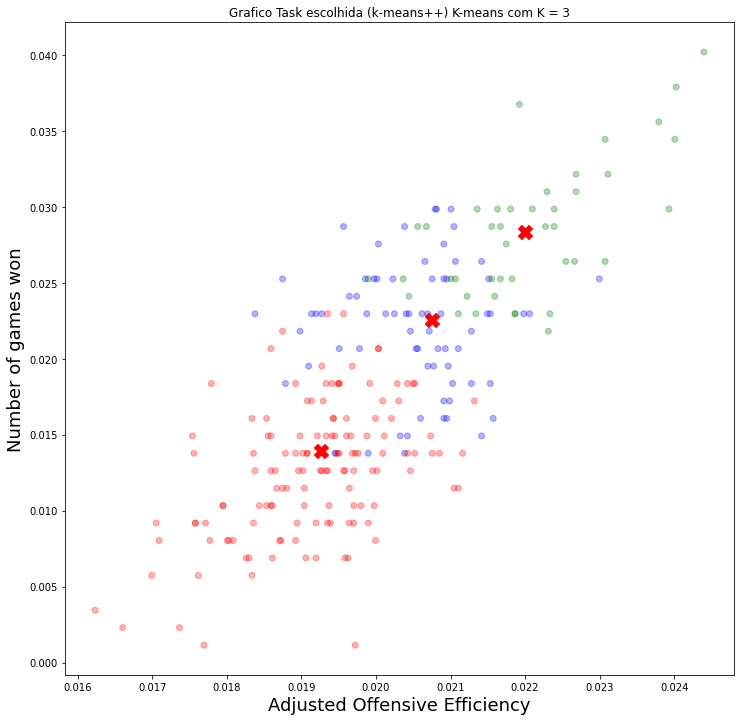

In [89]:
c1 = 2
c2 = 1
plotarGrafico(X_cl, x=normTesteCbb.iloc[:,c1], y=normTesteCbb.iloc[:,c2],  titulo= "Grafico Task escolhida (k-means++) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]], labelX='Adjusted Offensive Efficiency', labelY='Number of games won')

Adjusted Defensive Efficiency X Number of games won

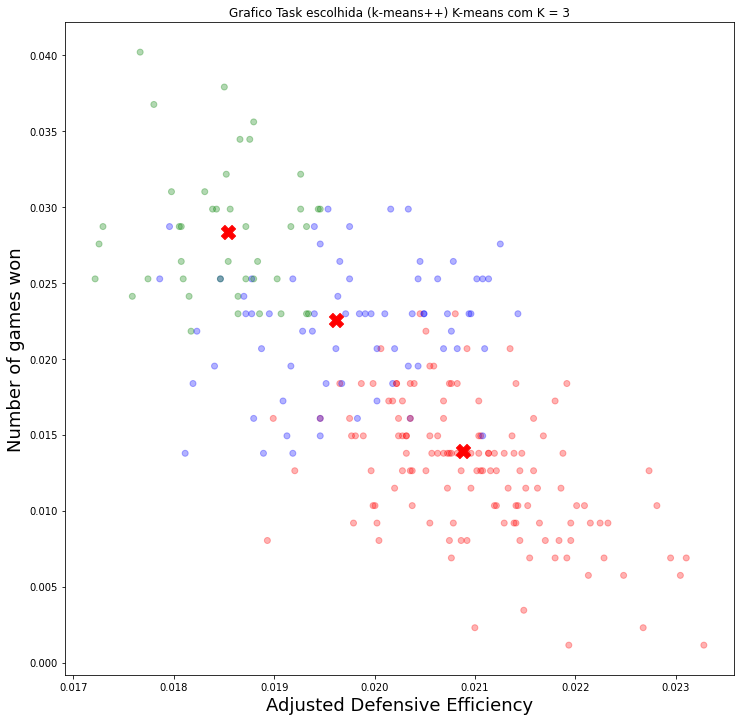

In [90]:
c1 = 3
c2 = 1
plotarGrafico(X_cl, x=normTesteCbb.iloc[:,c1], y=normTesteCbb.iloc[:,c2],  titulo= "Grafico Task escolhida (k-means++) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]], labelX='Adjusted Defensive Efficiency', labelY='Number of games won')

Two-Point Shooting Percentage X Adjusted Offensive Efficiency

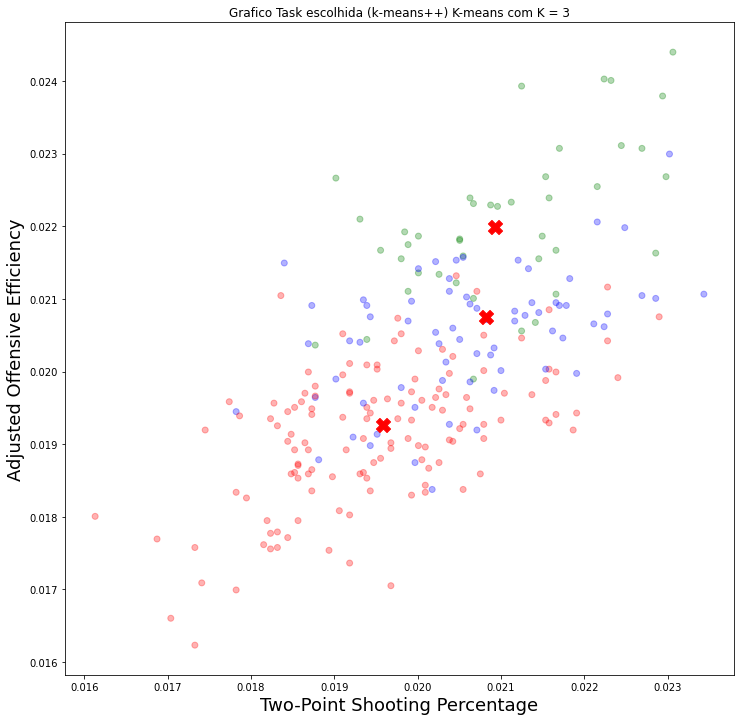

In [91]:
c1 = 13
c2 = 2
plotarGrafico(X_cl, x=normTesteCbb.iloc[:,c1], y=normTesteCbb.iloc[:,c2],  titulo= "Grafico Task escolhida (k-means++) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]], labelX='Two-Point Shooting Percentage', labelY='Adjusted Offensive Efficiency')

Three-Point Shooting Percentage X Adjusted Offensive Efficiency

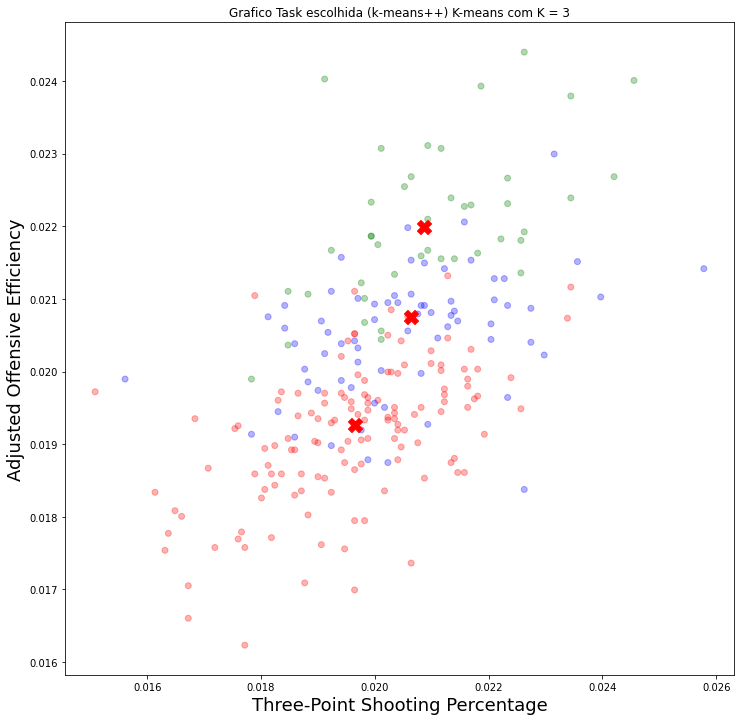

In [92]:
c1 = 15
c2 = 2
plotarGrafico(X_cl, x=normTesteCbb.iloc[:,c1], y=normTesteCbb.iloc[:,c2],  titulo= "Grafico Task escolhida (k-means++) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]], labelX='Three-Point Shooting Percentage', labelY='Adjusted Offensive Efficiency')

Adjusted Tempo X Number of games won

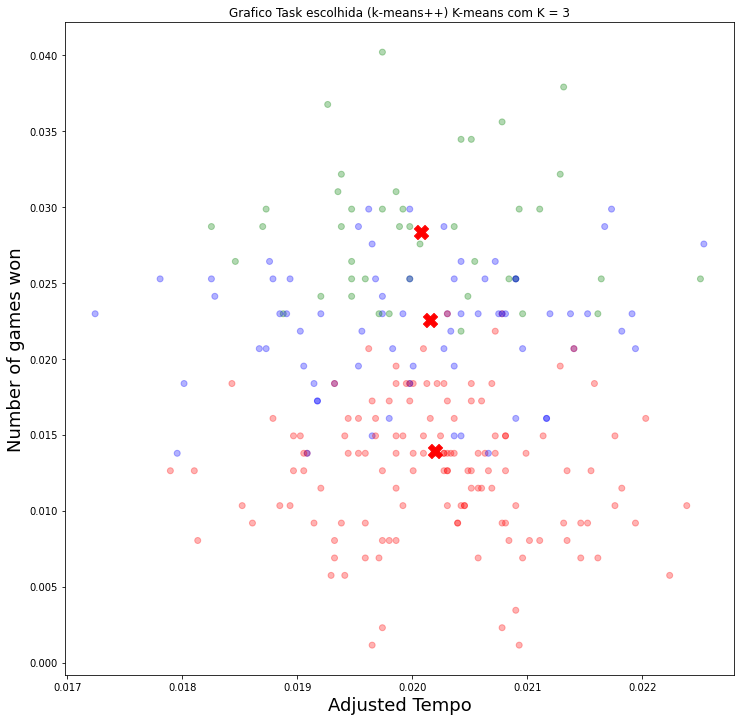

In [93]:
c1 = 17
c2 = 1
plotarGrafico(X_cl, x=normTesteCbb.iloc[:,c1], y=normTesteCbb.iloc[:,c2],  titulo= "Grafico Task escolhida (k-means++) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]], labelX='Adjusted Tempo', labelY='Number of games won')

**Método para usar o PCA do Sklearn**

Finalmente, aplicaremos o método PCA para redução de dimensionalidade, e analisaremos os resultados.

In [94]:
def PCA_calc(data, n):
  pca = PCA(n_components=n)
  return pd.DataFrame(data = pca.fit_transform(data))

**Reduzindo para 15 colunas**

In [95]:
novoDataSet = PCA_calc(normDataSetCbb, 15)

Calculando o Elbow para escolher um K

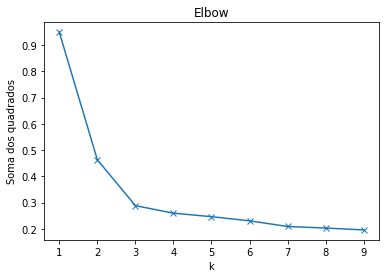

In [96]:
elbow(novoDataSet)

**Treinando com o método k-means junto ao PCA, e plotando o gráfico com k entre [1..4].**
  
  
  Procura-se o valor ideial dentro desse intervalo.

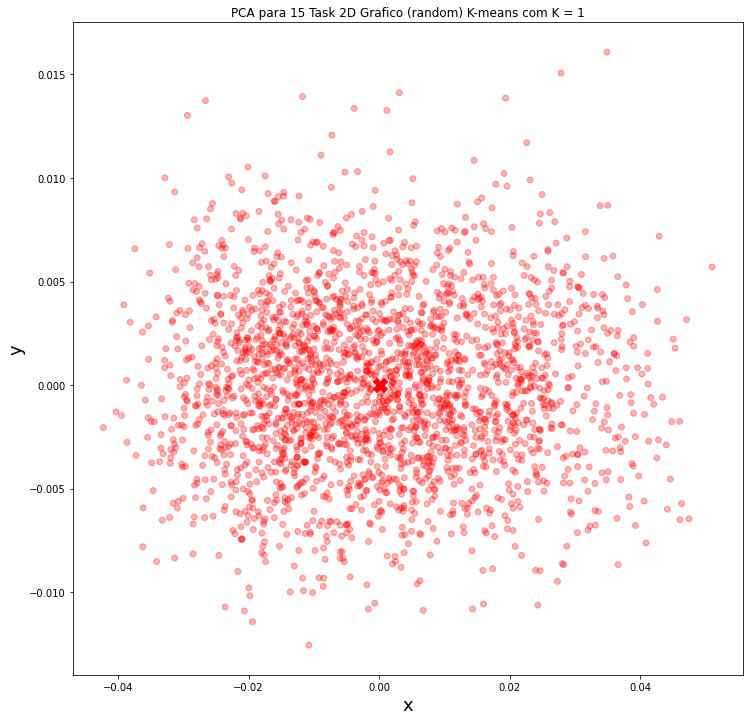

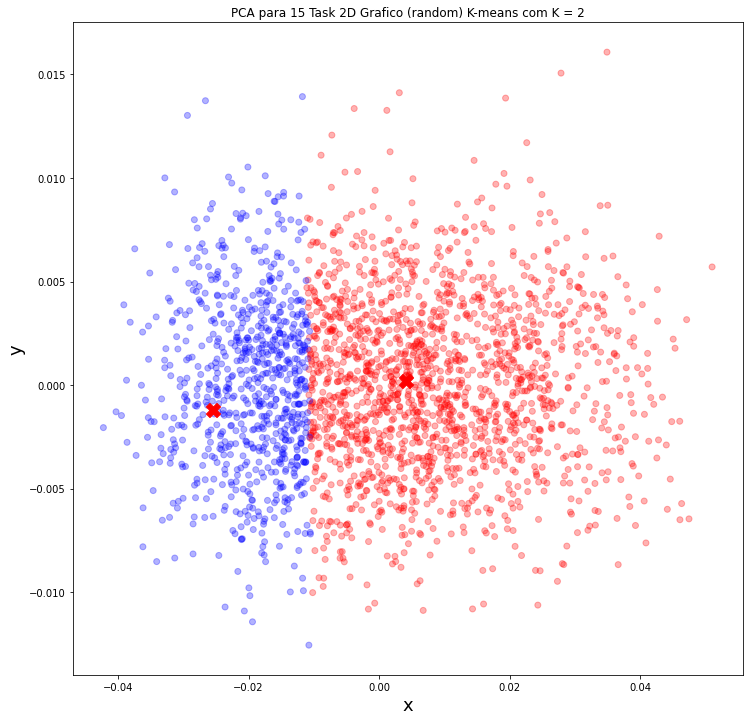

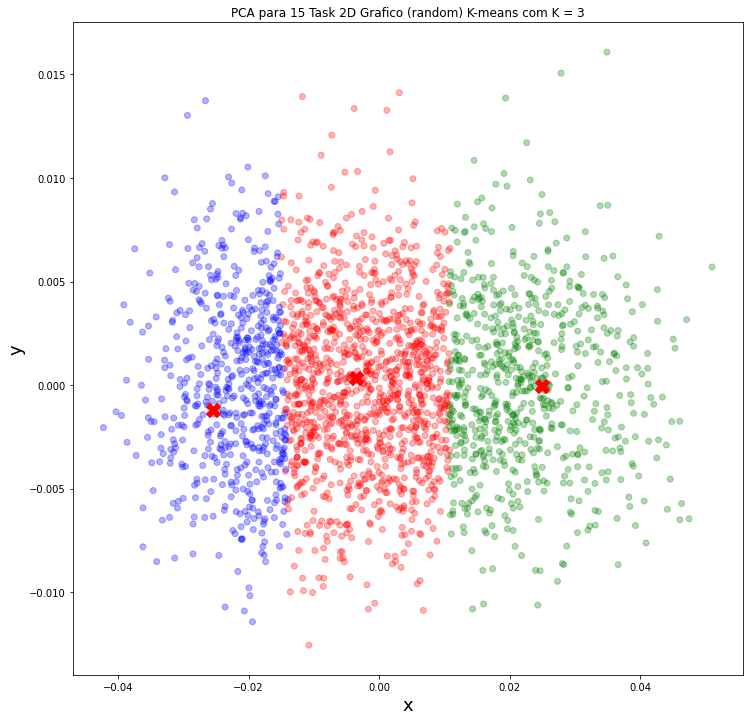

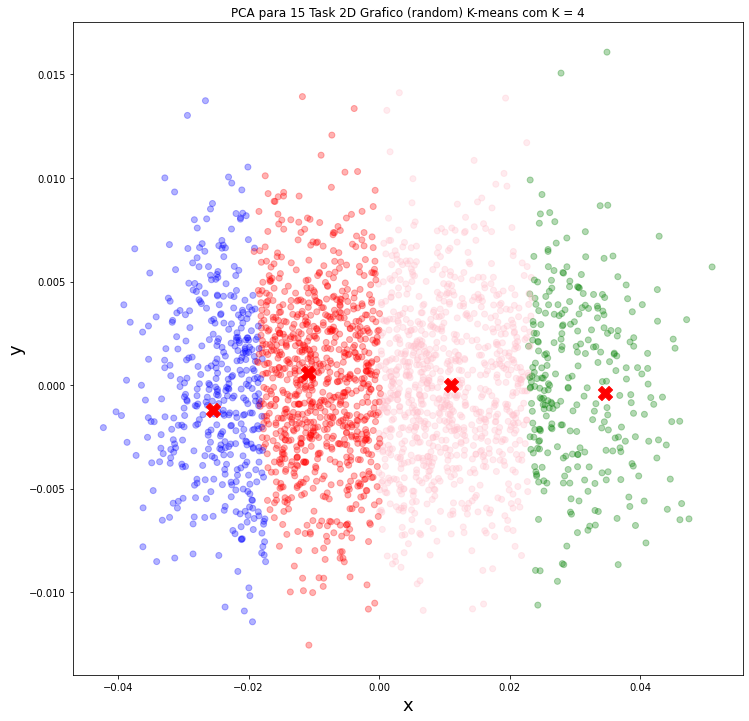

In [97]:
novoTreinoCbb, novoTesteCbb = splitData(novoDataSet, 0.9)
for k in range(1,5):
  km = KmeansTeste(k)
  km.fit(novoTreinoCbb)
  X_cl = km.predict(novoTesteCbb)
  c1 = 0
  c2 = 1
  plotarGrafico(X_cl, x=novoTesteCbb.iloc[:,c1], y=novoTesteCbb.iloc[:,c2],  titulo= "PCA para 15 Task 2D Grafico (random) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]])

Colunas 3 e 6

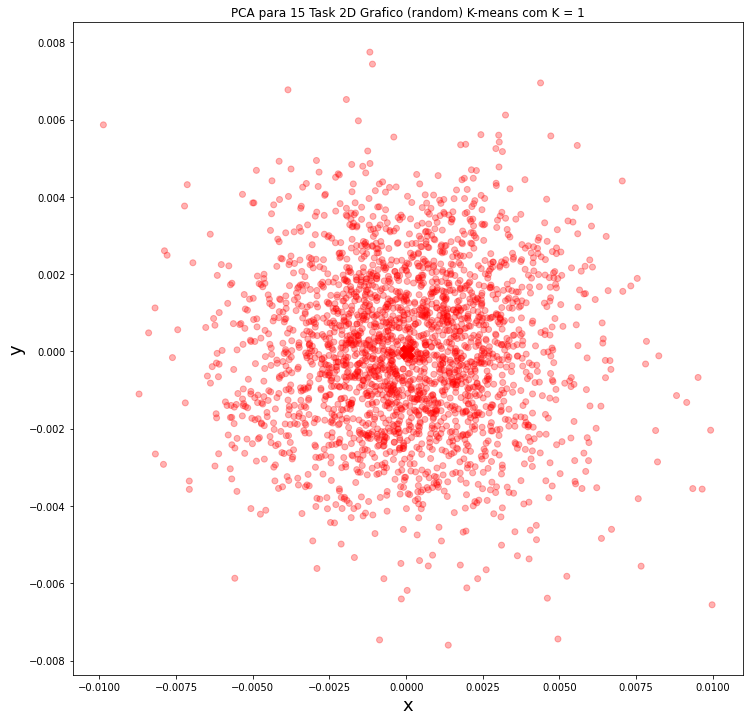

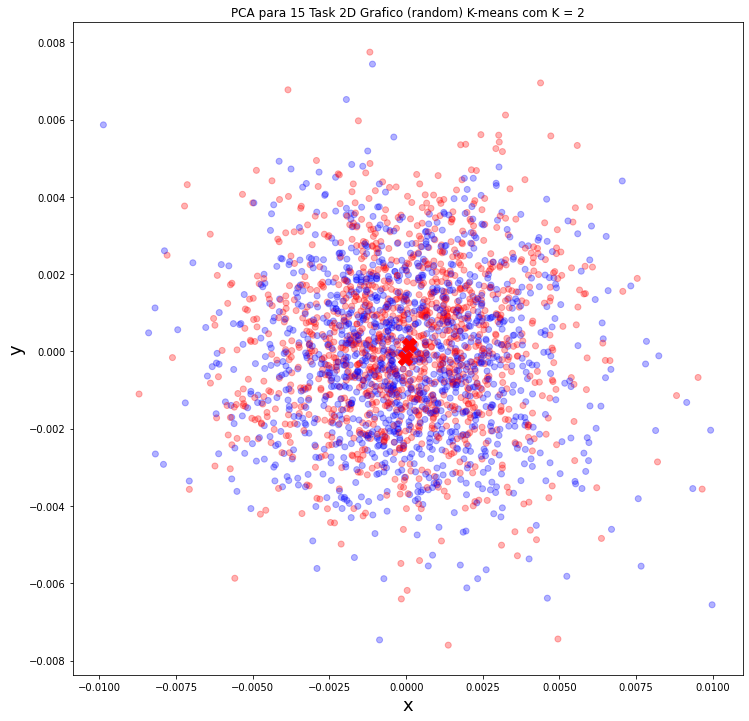

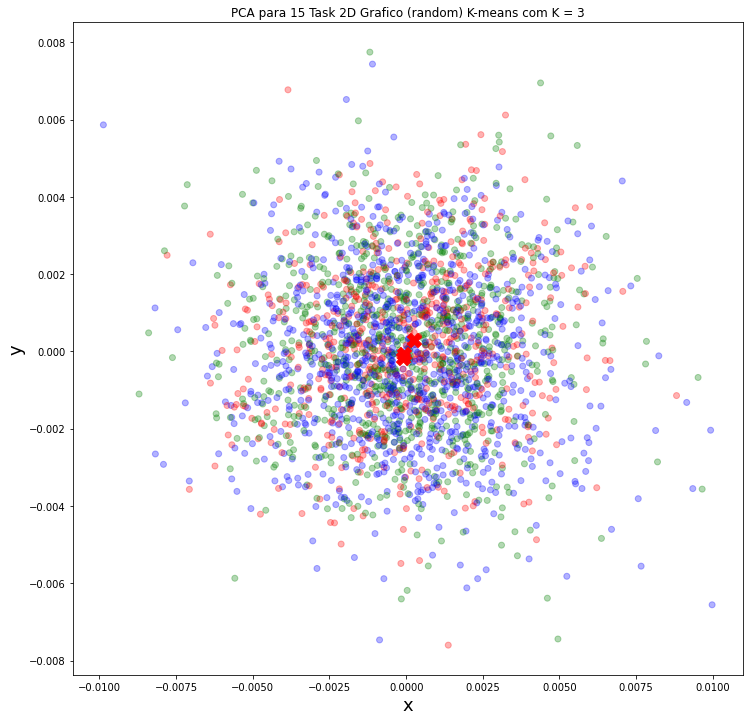

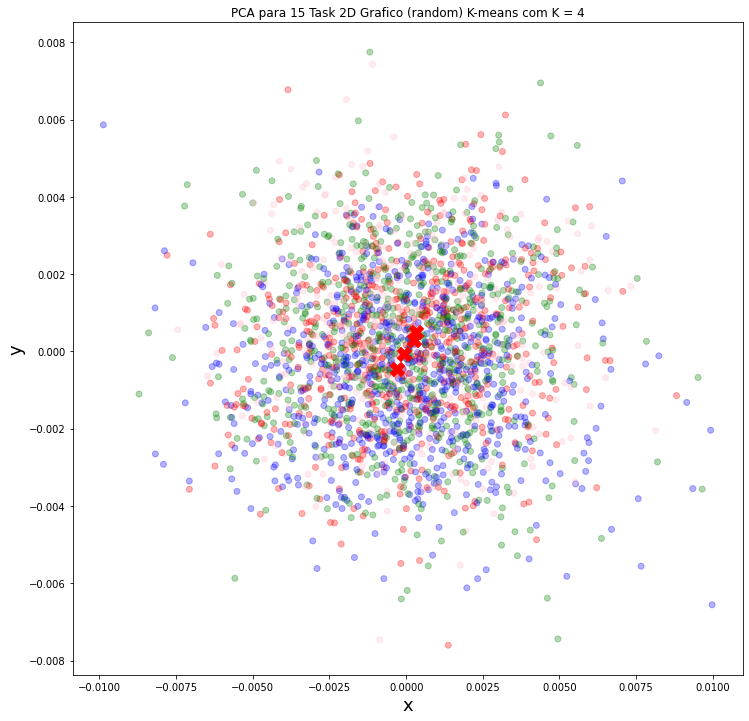

In [98]:
novoTreinoCbb, novoTesteCbb = splitData(novoDataSet, 0.9)
for k in range(1,5):
  km = KmeansTeste(k)
  km.fit(novoTreinoCbb)
  X_cl = km.predict(novoTesteCbb)
  c1 = 3
  c2 = 6
  plotarGrafico(X_cl, x=novoTesteCbb.iloc[:,c1], y=novoTesteCbb.iloc[:,c2],  titulo= "PCA para 15 Task 2D Grafico (random) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]])

**Reduzindo para 8 colunas**

Reduziremos mais colunas e avaliaremos semelhanças e diferenças.

In [99]:
novoDataSet = PCA_calc(normDataSetCbb, 8)

Calculando o Elbow para escolher um bom K

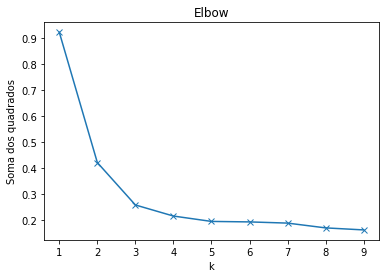

In [100]:
elbow(novoDataSet)

**Treinando com o metodo e plotando o gráfico com k entre [1..4], pois podemos ver que o valor ideial dentro desse intervalo**

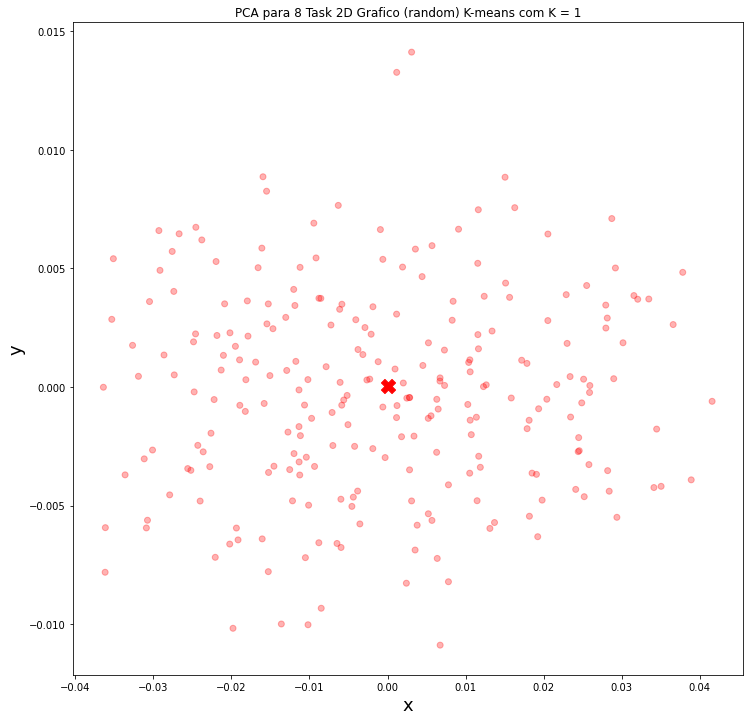

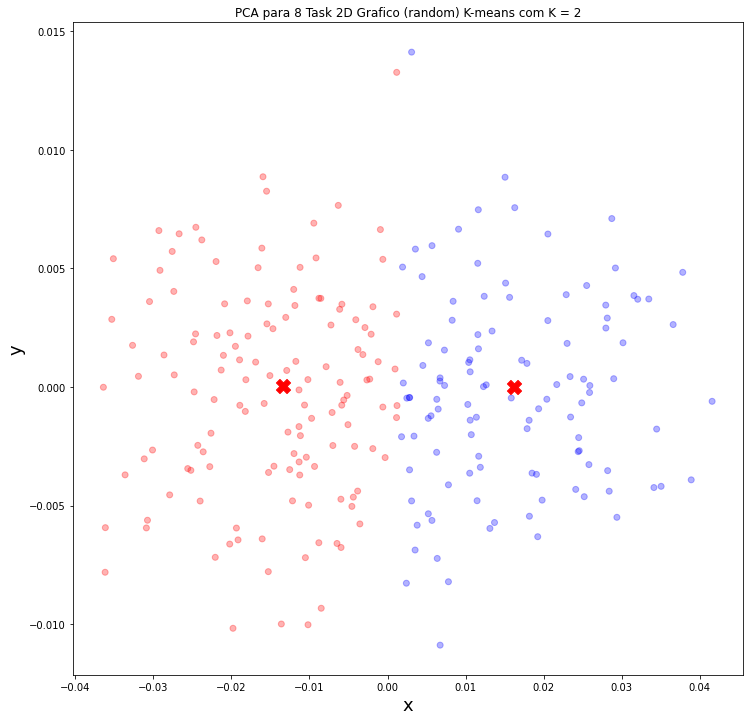

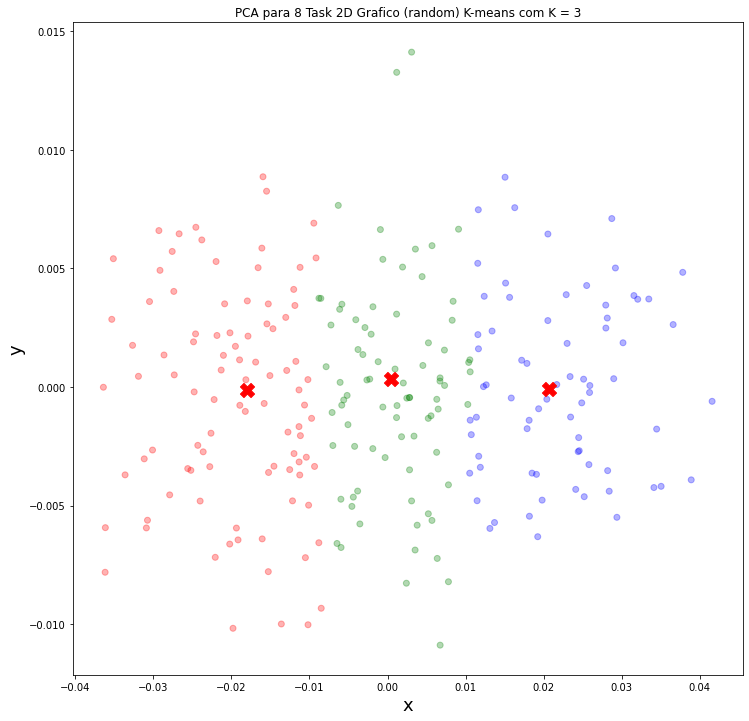

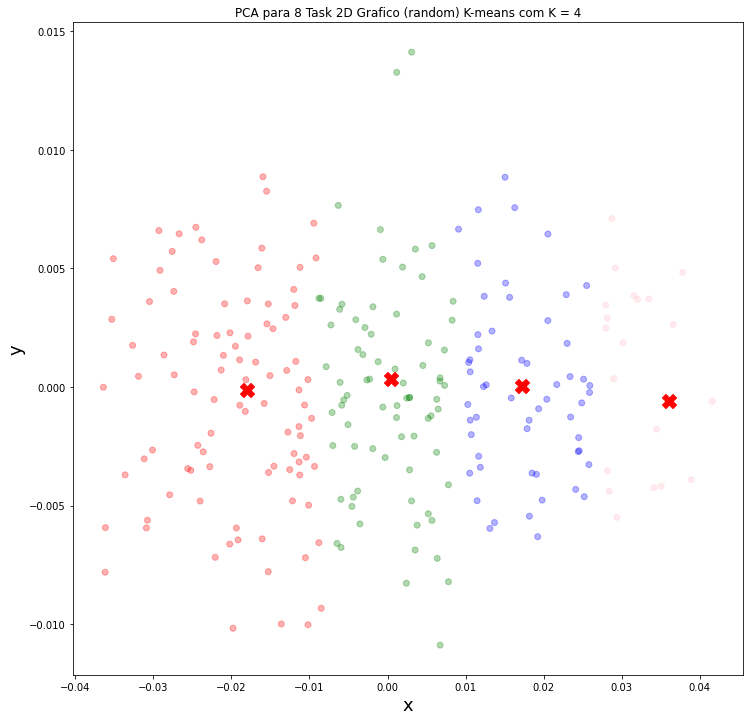

In [101]:
novoTreinoCbb, novoTesteCbb = splitData(novoDataSet, 0.9)
for k in range(1,5):
  km = KmeansTeste(k)
  km.fit(novoTreinoCbb)
  X_cl = km.predict(novoTesteCbb)
  c1 = 0
  c2 = 1
  plotarGrafico(X_cl, x=novoTesteCbb.iloc[:,c1], y=novoTesteCbb.iloc[:,c2],  titulo= "PCA para 8 Task 2D Grafico (random) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]])

Colunas 4 e 5

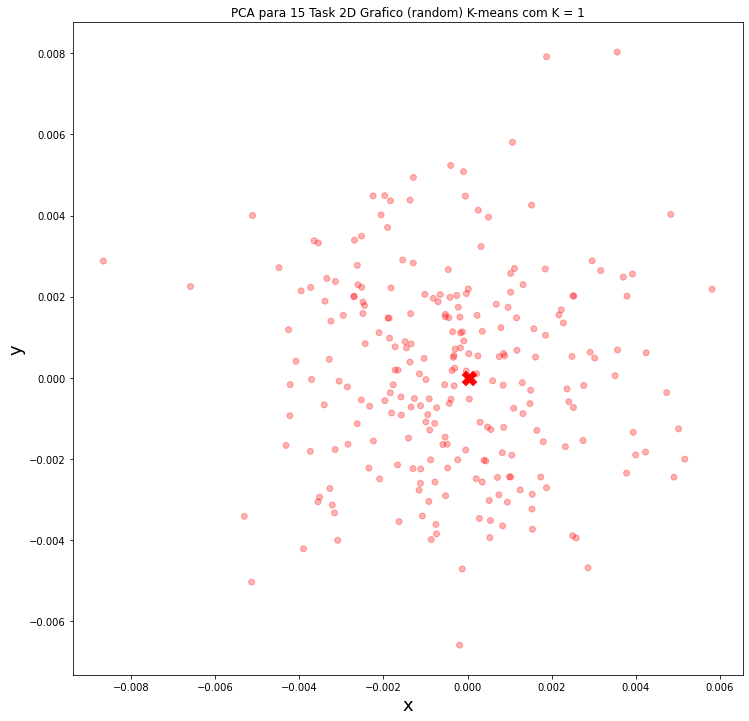

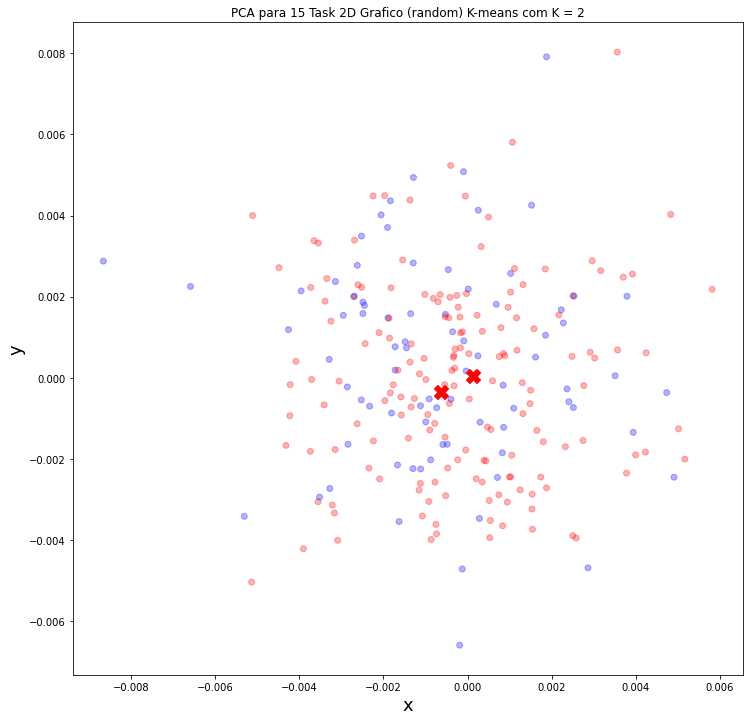

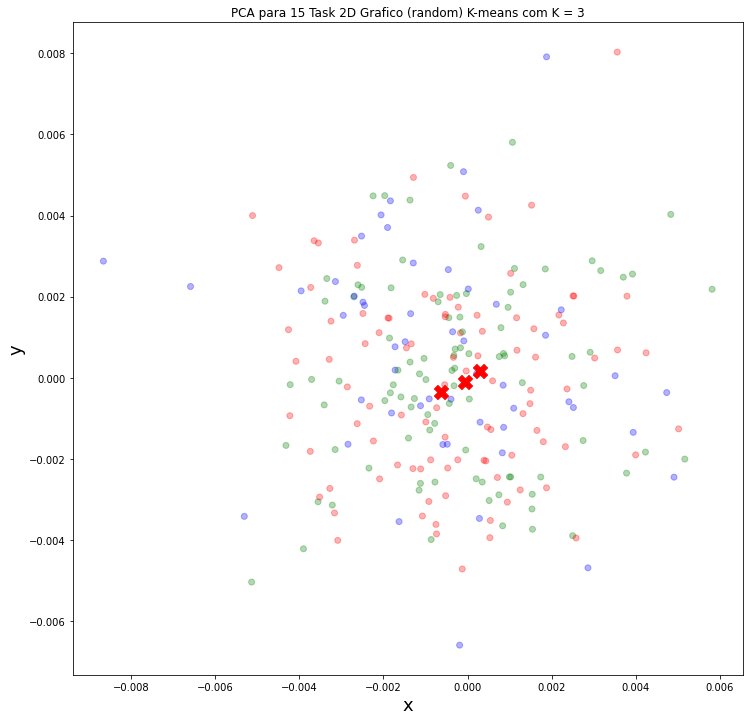

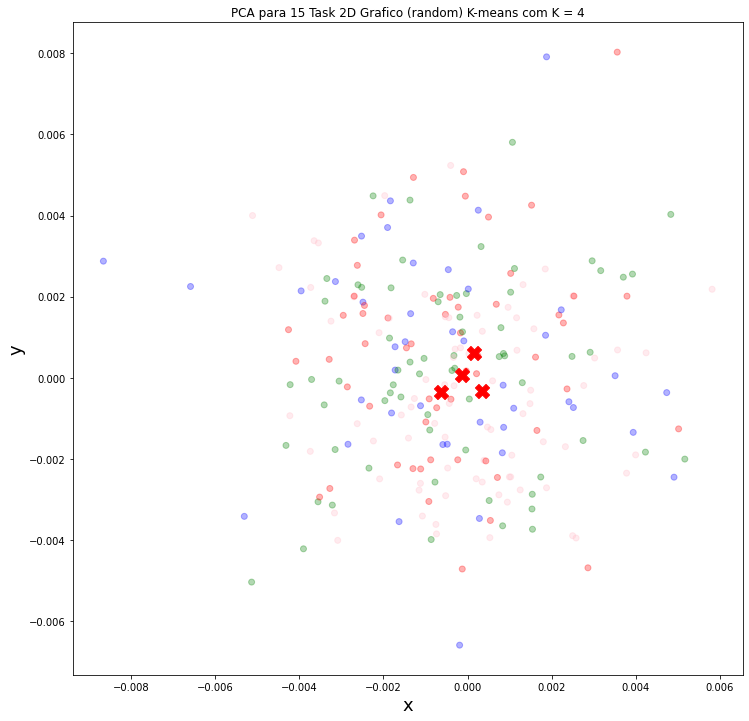

In [102]:
novoTreinoCbb, novoTesteCbb = splitData(novoDataSet, 0.9)
for k in range(1,5):
  km = KmeansTeste(k)
  km.fit(novoTreinoCbb)
  X_cl = km.predict(novoTesteCbb)
  c1 = 4
  c2 = 5
  plotarGrafico(X_cl, x=novoTesteCbb.iloc[:,c1], y=novoTesteCbb.iloc[:,c2],  titulo= "PCA para 15 Task 2D Grafico (random) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]])

**Reduzindo para 2 colunas**

In [103]:
novoDataSet = PCA_calc(normDataSetCbb, 2)

Calculando o Elbow para escolher um com K

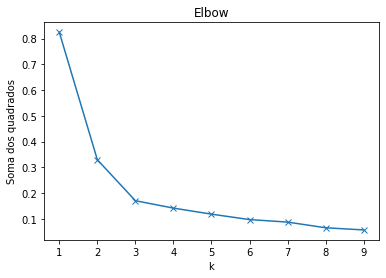

In [104]:
elbow(novoDataSet)

**Treinando com o metodo e plotando o gráfico com k entre [1..4]**


Procuramos o valor ideial dentro desse intervalo.

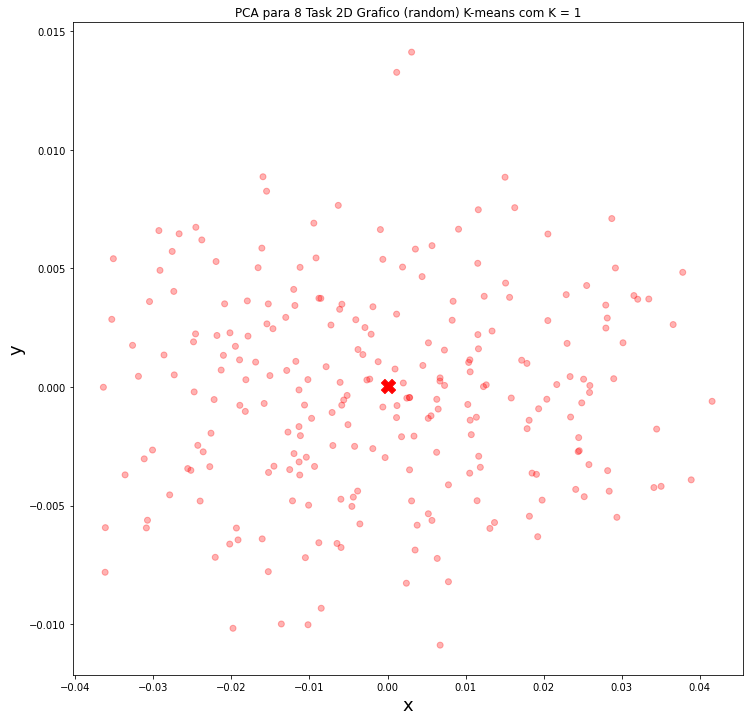

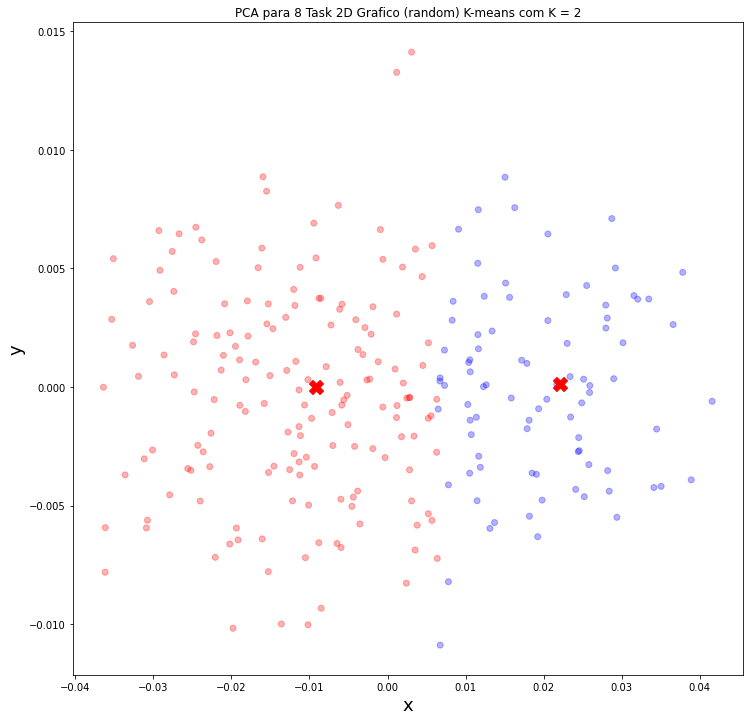

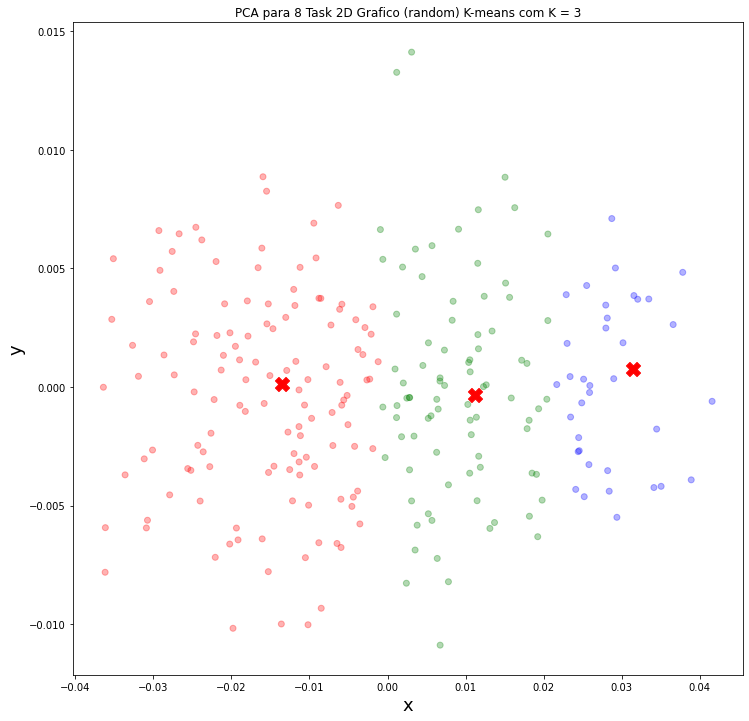

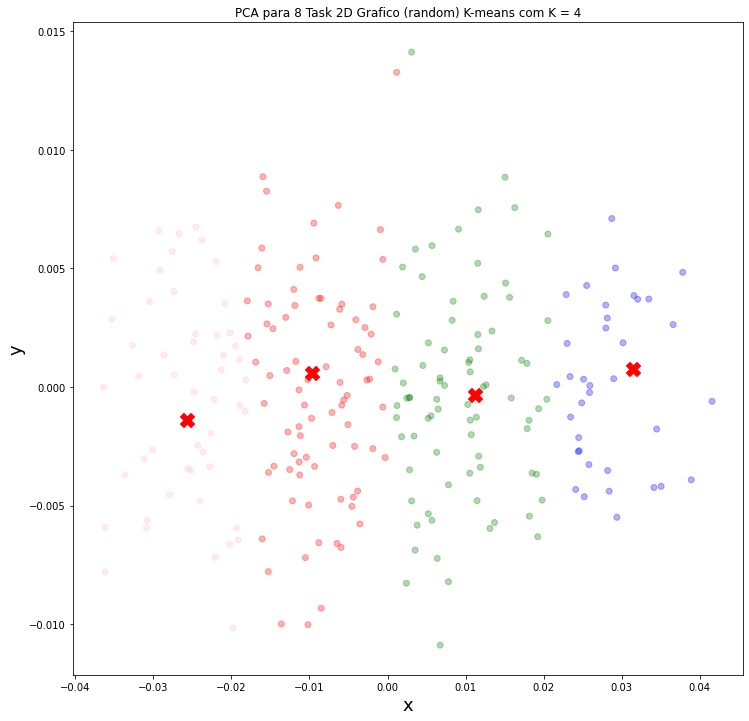

In [105]:
novoTreinoCbb, novoTesteCbb = splitData(novoDataSet, 0.9)
for k in range(1,5):
  km = KmeansTeste(k)
  km.fit(novoTreinoCbb)
  X_cl = km.predict(novoTesteCbb)
  c1 = 0
  c2 = 1
  plotarGrafico(X_cl, x=novoTesteCbb.iloc[:,c1], y=novoTesteCbb.iloc[:,c2],  titulo= "PCA para 8 Task 2D Grafico (random) K-means com K = " + str(k), centroides=[km.centroides[0:k,c1], km.centroides[0:k,c2]])

Comparando os dados de antes do PCA, podemos visualizar gráficos bem diferentes. Entretando, ao se calcular o Elbow, verificamos gráficos com densidades muito semelhantes. 

Já entre os gráficos após a aplicação do PCA, usando as coordenadas (colunas) 0 e 1, verificamos gráficos bem semelhantes entre eles.

Entretanto, ao visualizar a distribuição de outras coordenadas, quando possível, verificamos que visualmente os clusters se sobrepoem.

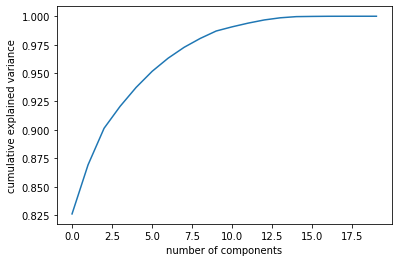

In [114]:
pca = PCA().fit(normDataSetCbb)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');  

Analisando o grafico  da variancia acumulativa, podemos perceber que no caso de nosso dataset escolhido podemos perceber que mesmo que abaixando para 2 componentes, corresponde a um pouco mais que 85% da variancia

Abaixo faço uma analise das informaçoes perdidas em comparação ao novo conjunto de componentes. No qual os pontos azuis são do dataset original e o laranja do reduzido.

Quando reduzimos para **2** componentes aparenta que estamos tendo uma perda significativa de informações.

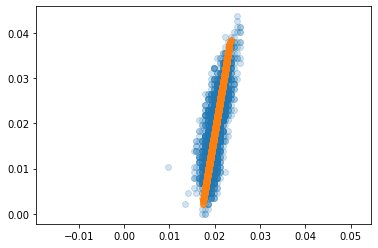

In [116]:
pca = PCA(n_components=2)
pca.fit(normDataSetCbb)
X_pca = pca.transform(normDataSetCbb)
X_new = pca.inverse_transform(X_pca)
plt.scatter(normDataSetCbb.iloc[:, 0], normDataSetCbb.iloc[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

Quando reduzimos para **8** componentes da para se perceber que acabamos perdendo muita pouca informaçãos em relação aos dados originais.

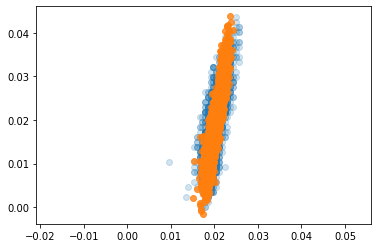

In [117]:
pca = PCA(n_components=8)
pca.fit(normDataSetCbb)
X_pca = pca.transform(normDataSetCbb)
X_new = pca.inverse_transform(X_pca)
plt.scatter(normDataSetCbb.iloc[:, 0], normDataSetCbb.iloc[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

Quando reduzimos para **15** componentes não percebesse nenhuma perda de informações, até mesmo os pontos que aparentam ser outliers foram incluidos dentro das 15 dimensões.

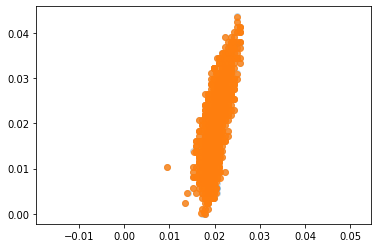

In [118]:
pca = PCA(n_components=15)
pca.fit(normDataSetCbb)
X_pca = pca.transform(normDataSetCbb)
X_new = pca.inverse_transform(X_pca)
plt.scatter(normDataSetCbb.iloc[:, 0], normDataSetCbb.iloc[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');